In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import cv2

In [79]:
c = 0.5
epsilon0 = 1.0
mu_0 = 1.0 / (epsilon0 * c**2)
m_unit = 1.0
r_m = 1/9
m_electron = 1 * m_unit
m_ion = m_electron / r_m
t_r = 1.0/1.0
r_q = 1.0
n_e = 5 * 2.0 / (1.0 + t_r) #ここは手動で調整すること
B0 = np.sqrt(n_e) / 1 / np.sqrt(2/(1+t_r))
n_i = int(n_e / r_q)
T_i  = (B0**2 / 2.0 / mu_0) / (n_i + n_e * t_r)
T_e = T_i * t_r
debye_length = 1.0
q_unit = np.sqrt(epsilon0 * T_e / n_e) / debye_length
q_electron = -1 * q_unit
q_ion = r_q * q_unit
debye_length = np.sqrt(epsilon0 * T_e / n_e / q_electron**2)
omega_pe = np.sqrt(n_e * q_electron**2 / m_electron / epsilon0)
omega_pi = np.sqrt(n_i * q_ion**2 / m_ion / epsilon0)
omega_ce = q_electron * B0 / m_electron
omega_ci = q_ion * B0 / m_ion
ion_inertial_length = c / omega_pi
sheat_thickness = 1.0 * ion_inertial_length
v_electron = np.array([0.0, 0.0, c * debye_length / sheat_thickness * np.sqrt(2 / (1.0 + 1/t_r))])
v_ion = -v_electron / t_r
v_thermal_electron = np.sqrt(2.0 * T_e / m_electron)
v_thermal_ion = np.sqrt(2.0 * T_i / m_ion)
V_Ai = B0 / np.sqrt(mu_0 * n_i * m_ion)
V_Ae = B0 / np.sqrt(mu_0 * n_e * m_electron)
beta_e = n_e * T_e / (B0**2 / 2 / mu_0)
beta_i = n_i * T_i / (B0**2 / 2 / mu_0)

dx = 1.0
dy = 1.0
n_x = int(ion_inertial_length * 100)
n_y = int(ion_inertial_length * 50)
x_min = 0.0 * dx
y_min = 0.0 * dy
x_max = n_x * dx
y_max = n_y * dy
x_coordinate = np.arange(0.0, x_max, dx)
y_coordinate = np.arange(0.0, y_max, dy)
dt = 0.5
step = 20000
t_max = step * dt

n_ion = int(n_x * n_i * 2.0 * sheat_thickness)
n_electron = int(n_ion * abs(q_ion / q_electron))
n_ion_background = int(n_x * n_y * 0.2 * n_i)
n_electron_background = int(n_x * n_y * 0.2 * n_e)
n_particle = n_ion + n_ion_background + n_electron + n_electron_background
print(f"total number of particles is {n_particle}.")
print(f"omega_pe = {omega_pe}, omega_ce = {omega_ce}")
print(f"total time step of 100/Omega_ci = {int(100 / omega_ci/dt)} (10/Omega_ci = {int(10/omega_ci/dt)})")

total number of particles is 430080.
omega_pe = 0.25, omega_ce = -0.25000000000000006
total time step of 100/Omega_ci = 7199 (10/Omega_ci = 719)


### 数密度

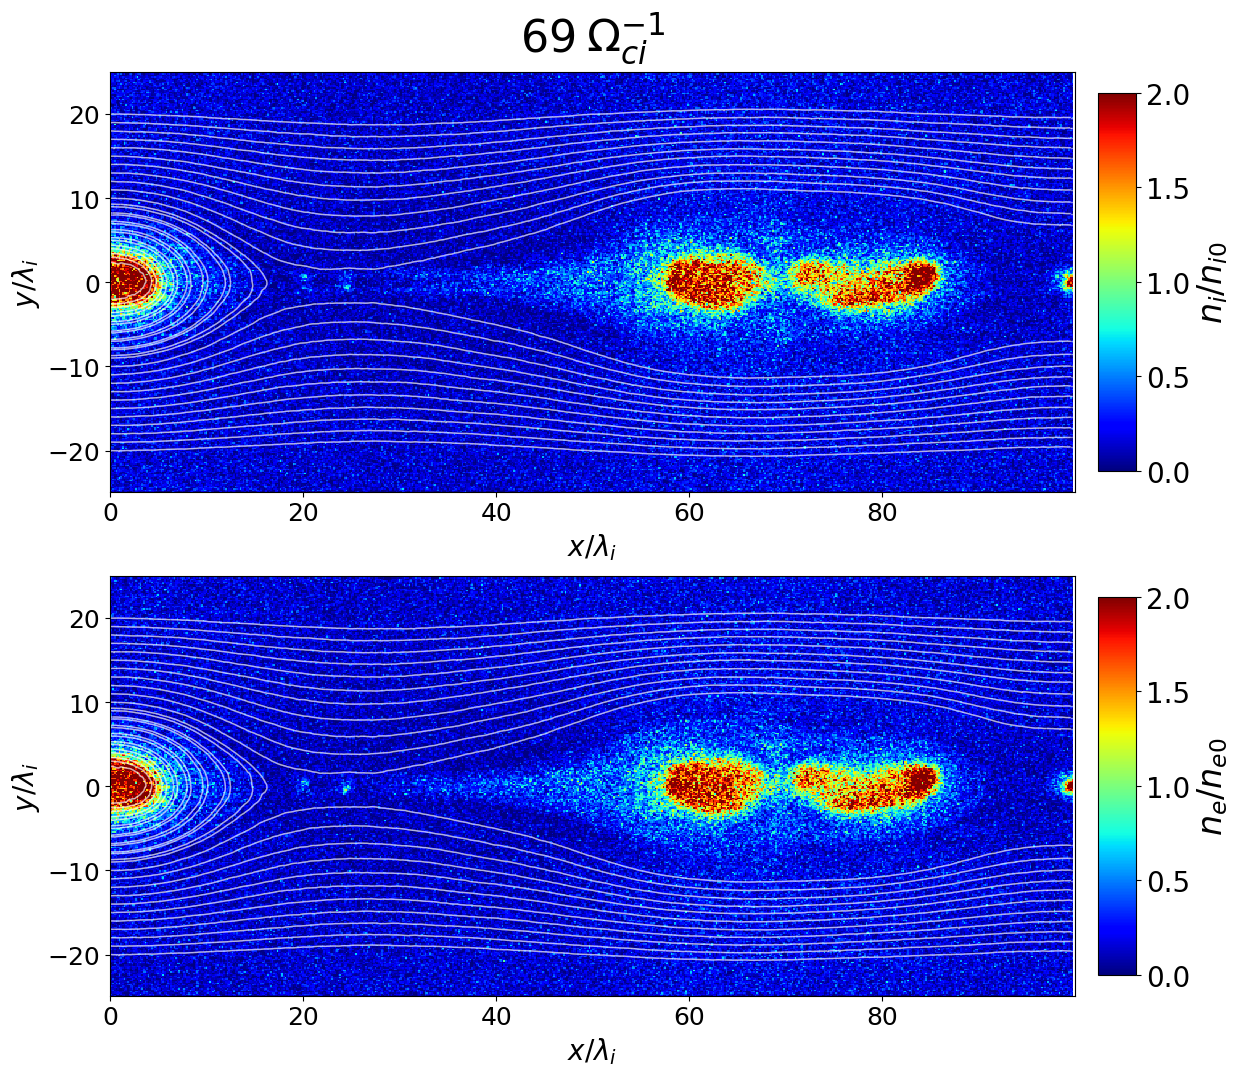

In [81]:
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

dirname = "mr2008_mr9_tr1"
filename = "tmp.png"
file_num = int(10.0/omega_ci/dt) * 7

X, Y = np.meshgrid(x_coordinate, y_coordinate - y_max/2) / ion_inertial_length
start_y_enlarged = np.arange(-20.0, 20.0+0.1, 1)
start_points_enlarged = np.array([np.zeros(start_y_enlarged.shape), start_y_enlarged])
start_y = np.arange(-y_max/2/ion_inertial_length, y_max/2/ion_inertial_length, 5)
start_points = np.array([np.zeros(start_y.shape), start_y])

zeroth_moment_ion = np.loadtxt(f'{dirname}/mr2008_zeroth_moment_ion_{file_num}.csv', delimiter=',')[:, 0].reshape(n_x, n_y)
zeroth_moment_electron = np.loadtxt(f'{dirname}/mr2008_zeroth_moment_electron_{file_num}.csv', delimiter=',')[:, 0].reshape(n_x, n_y)
B = np.loadtxt(f'{dirname}/mr2008_B_{file_num}.csv', delimiter=',')[:, :3].reshape(n_x, n_y, 3)

mappable = ax1.pcolormesh(X, Y, zeroth_moment_ion.T / n_i, cmap='jet', vmin=0.0, vmax=2.0)
cbar = fig.colorbar(mappable, ax=ax1, pad=0.02, shrink=0.9, aspect=10, ticks=np.arange(0.0, 2.1, 0.5))
cbar.set_label(r'$n_i / n_{i0}$', fontsize=24)
cbar.ax.tick_params(labelsize=20)
ax1.streamplot(X, Y, B[:, :, 0].T, B[:, :, 1].T, broken_streamlines=False, 
            start_points=start_points_enlarged.T, color='white', density = 100, linewidth=1, arrowsize=0)
ax1.set_xlabel('$x / \lambda_i$', fontsize=20)
ax1.set_ylabel('$y / \lambda_i$', fontsize=20)
ax1.set_xlim(0.0, x_max/ion_inertial_length+0.1)
ax1.set_ylim(-y_max/2/ion_inertial_length, y_max/2/ion_inertial_length + 0.1)
ax1.tick_params(labelsize=18)
ax1.set_yticks([-20.0, -10.0, 0.0, 10.0, 20.0])
ax1.text(0.5, 1.05, str(int(file_num/(1.0/omega_ci/dt))) + r"$ \: \Omega_{ci}^{-1}$", ha='center', transform=ax1.transAxes, fontsize=32)


mappable = ax2.pcolormesh(X, Y, zeroth_moment_electron.T / n_e, cmap='jet', vmin=0.0, vmax=2.0)
cbar = fig.colorbar(mappable, ax=ax2, pad=0.02, shrink=0.9, aspect=10, ticks=np.arange(0.0, 2.1, 0.5))
cbar.set_label(r'$n_e / n_{e0}$', fontsize=24)
cbar.ax.tick_params(labelsize=20)
ax2.streamplot(X, Y, B[:, :, 0].T, B[:, :, 1].T, broken_streamlines=False, 
            start_points=start_points_enlarged.T, color='white', density = 100, linewidth=1, arrowsize=0)
ax2.set_xlabel('$x / \lambda_i$', fontsize=20)
ax2.set_ylabel('$y / \lambda_i$', fontsize=20)
ax2.set_xlim(0.0, x_max/ion_inertial_length+0.1)
ax2.set_ylim(-y_max/2/ion_inertial_length, y_max/2/ion_inertial_length + 0.1)
ax2.tick_params(labelsize=18)
ax2.set_yticks([-20.0, -10.0, 0.0, 10.0, 20.0])

fig.savefig(filename, dpi=200)

c:\Users\keita\anaconda3\lib\site-packages\matplotlib\streamplot.py:600: RuntimeWarning: overflow encountered in double_scalars
  ds = min(maxds, 0.85 * ds * (maxerror / error) ** 0.5)


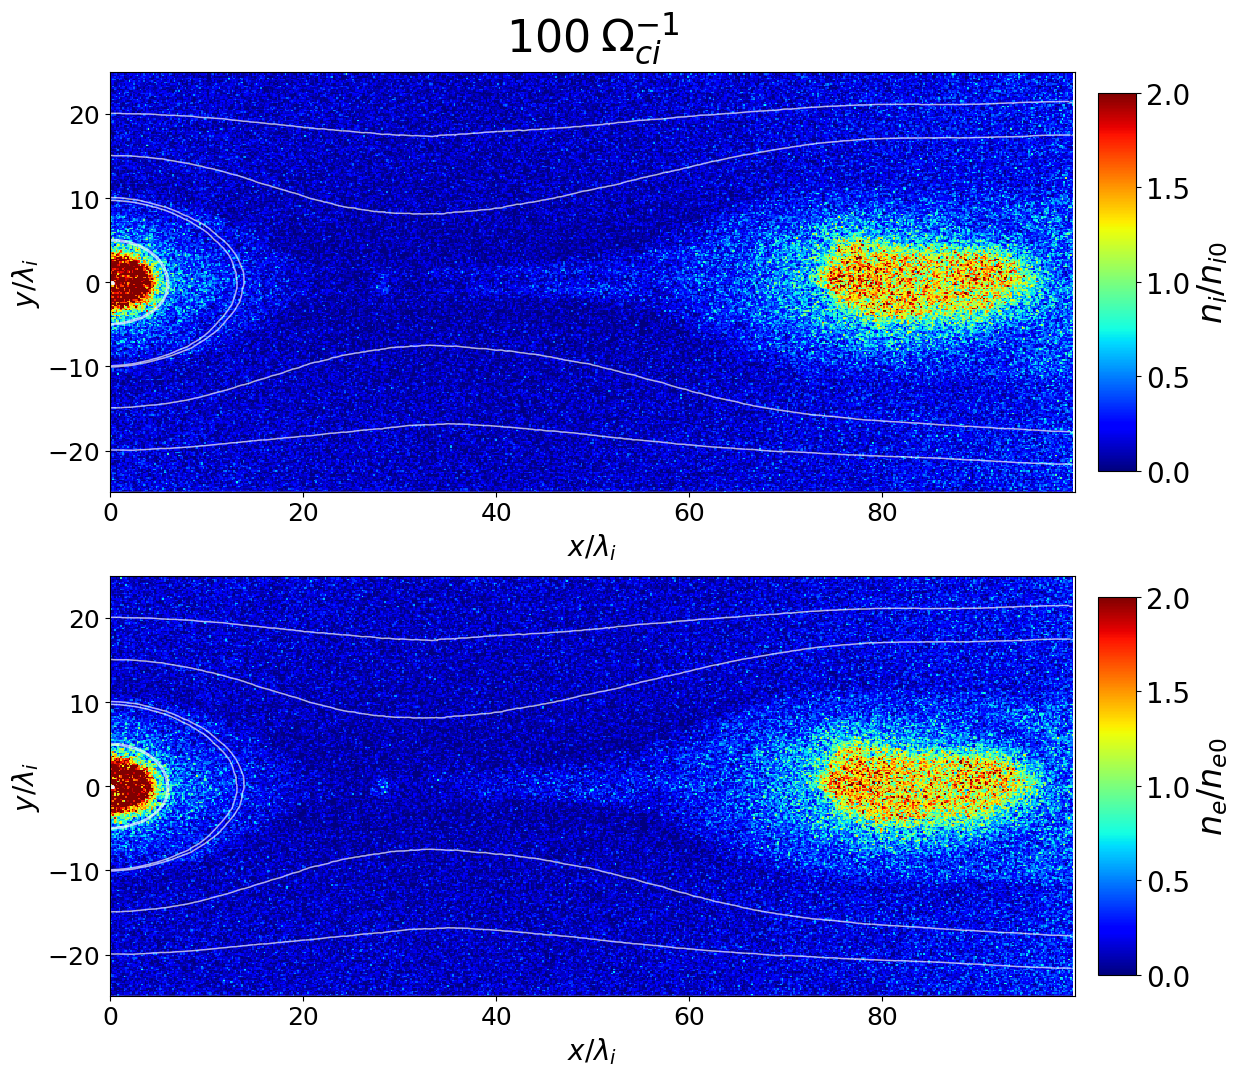

In [82]:
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

interval = 1
number_of_results = 11
dirname = "mr2008_mr9_tr1"
savedir = "pictures_mr9_tr1_n"

X, Y = np.meshgrid(x_coordinate, y_coordinate - y_max/2) / ion_inertial_length
start_y_enlarged = np.arange(-y_max/2/ion_inertial_length+5, y_max/2/ion_inertial_length-5+0.1, 2.5)
start_points_enlarged = np.array([np.zeros(start_y_enlarged.shape), start_y_enlarged])
start_y = np.arange(-y_max/2/ion_inertial_length, y_max/2/ion_inertial_length, 5)
start_points = np.array([np.zeros(start_y.shape), start_y])

for k in range(number_of_results):
    ax1.clear()
    ax2.clear()

    zeroth_moment_ion = np.loadtxt(f'{dirname}/mr2008_zeroth_moment_ion_{k*int(10/omega_ci/dt)}.csv', delimiter=',')[:, 0].reshape(n_x, n_y)
    zeroth_moment_electron = np.loadtxt(f'{dirname}/mr2008_zeroth_moment_electron_{k*int(10/omega_ci/dt)}.csv', delimiter=',')[:, 0].reshape(n_x, n_y)
    B = np.loadtxt(f'{dirname}/mr2008_B_{k*int(10/omega_ci/dt)}.csv', delimiter=',')[:, :3].reshape(n_x, n_y, 3)

    if k == 0:
        mappable = ax1.pcolormesh(X, Y, zeroth_moment_ion.T / n_i, cmap='jet', vmin=0.0, vmax=2.0)
        cbar = fig.colorbar(mappable, ax=ax1, pad=0.02, shrink=0.9, aspect=10, ticks=np.arange(0.0, 2.1, 0.5))
        cbar.set_label(r'$n_i / n_{i0}$', fontsize=24)
        cbar.ax.tick_params(labelsize=20)
    else:
        ax1.pcolormesh(X, Y, zeroth_moment_ion.T / n_i, cmap='jet', vmin=0.0, vmax=2.0)

    ax1.streamplot(X, Y, B[:, :, 0].T, B[:, :, 1].T, broken_streamlines=False, 
                  start_points=start_points_enlarged.T, color='white', density = 100, linewidth=1, arrowsize=0)
    ax1.set_xlabel('$x / \lambda_i$', fontsize=20)
    ax1.set_ylabel('$y / \lambda_i$', fontsize=20)
    ax1.set_xlim(0.0, x_max/ion_inertial_length+0.1)
    ax1.set_ylim(-20.0, 20.0+0.1)
    ax1.tick_params(labelsize=18)
    ax1.set_yticks([-20.0, -10.0, 0.0, 10.0, 20.0])
    ax1.text(0.5, 1.05, str(10 * k) + r"$ \: \Omega_{ci}^{-1}$", ha='center', transform=ax1.transAxes, fontsize=32)

    if k == 0:
        mappable = ax2.pcolormesh(X, Y, zeroth_moment_electron.T / n_e, cmap='jet', vmin=0.0, vmax=2.0)
        cbar = fig.colorbar(mappable, ax=ax2, pad=0.02, shrink=0.9, aspect=10, ticks=np.arange(0.0, 2.1, 0.5))
        cbar.set_label(r'$n_e / n_{e0}$', fontsize=24)
        cbar.ax.tick_params(labelsize=20)
    else:
        ax2.pcolormesh(X, Y, zeroth_moment_electron.T / n_e, cmap='jet', vmin=0.0, vmax=2.0)

    ax2.streamplot(X, Y, B[:, :, 0].T, B[:, :, 1].T, broken_streamlines=False, 
                  start_points=start_points_enlarged.T, color='white', density = 100, linewidth=1, arrowsize=0)
    ax2.set_xlabel('$x / \lambda_i$', fontsize=20)
    ax2.set_ylabel('$y / \lambda_i$', fontsize=20)
    ax2.set_xlim(0.0, x_max/ion_inertial_length+0.1)
    ax2.set_ylim(-20.0, 20.0+0.1)
    ax2.tick_params(labelsize=18)
    ax2.set_yticks([-20.0, -10.0, 0.0, 10.0, 20.0])

    fig.savefig(f'./{savedir}/{k}.png', dpi=200)


    ax1.clear()
    ax2.clear()

    ax1.pcolormesh(X, Y, zeroth_moment_ion.T / n_i, cmap='jet', vmin=0.0, vmax=2.0)
    ax1.streamplot(X, Y, B[:, :, 0].T, B[:, :, 1].T, broken_streamlines=False, 
                  start_points=start_points.T, color='white', density = 100, linewidth=1, arrowsize=0)
    ax1.set_xlabel('$x / \lambda_i$', fontsize=20)
    ax1.set_ylabel('$y / \lambda_i$', fontsize=20)
    ax1.set_xlim(0.0, x_max/ion_inertial_length+0.1)
    ax1.set_ylim(-y_max/2/ion_inertial_length, y_max/2/ion_inertial_length+0.1)
    ax1.tick_params(labelsize=18)
    ax1.text(0.5, 1.05, str(10 * k) + r"$ \: \Omega_{ci}^{-1}$", ha='center', transform=ax1.transAxes, fontsize=32)

    ax2.pcolormesh(X, Y, zeroth_moment_electron.T / n_e, cmap='jet', vmin=0.0, vmax=2.0)
    ax2.streamplot(X, Y, B[:, :, 0].T, B[:, :, 1].T, broken_streamlines=False, 
                  start_points=start_points.T, color='white', density = 100, linewidth=1, arrowsize=0)
    ax2.set_xlabel('$x / \lambda_i$', fontsize=20)
    ax2.set_ylabel('$y / \lambda_i$', fontsize=20)
    ax2.set_xlim(0.0, x_max/ion_inertial_length+0.1)
    ax2.tick_params(labelsize=18)
    ax2.set_ylim(-y_max/2/ion_inertial_length, y_max/2/ion_inertial_length+0.1)

    fig.savefig(f'./{savedir}/{k+number_of_results}.png', dpi=200)
    

In [83]:
filename = "mr2008_mr9_tr1.mp4"
savedir = "pictures_mr9_tr1_n/"
number_of_results = 11

img = cv2.imread(f'./{savedir}/0.png')
framesize = (img.shape[1], img.shape[0])
fps = 2.0

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename, fourcc=fourcc, fps=fps, frameSize=framesize)

for i in range(number_of_results):
    img = cv2.imread(f'./{savedir}/{i}.png')
    video.write(img)
video.release()

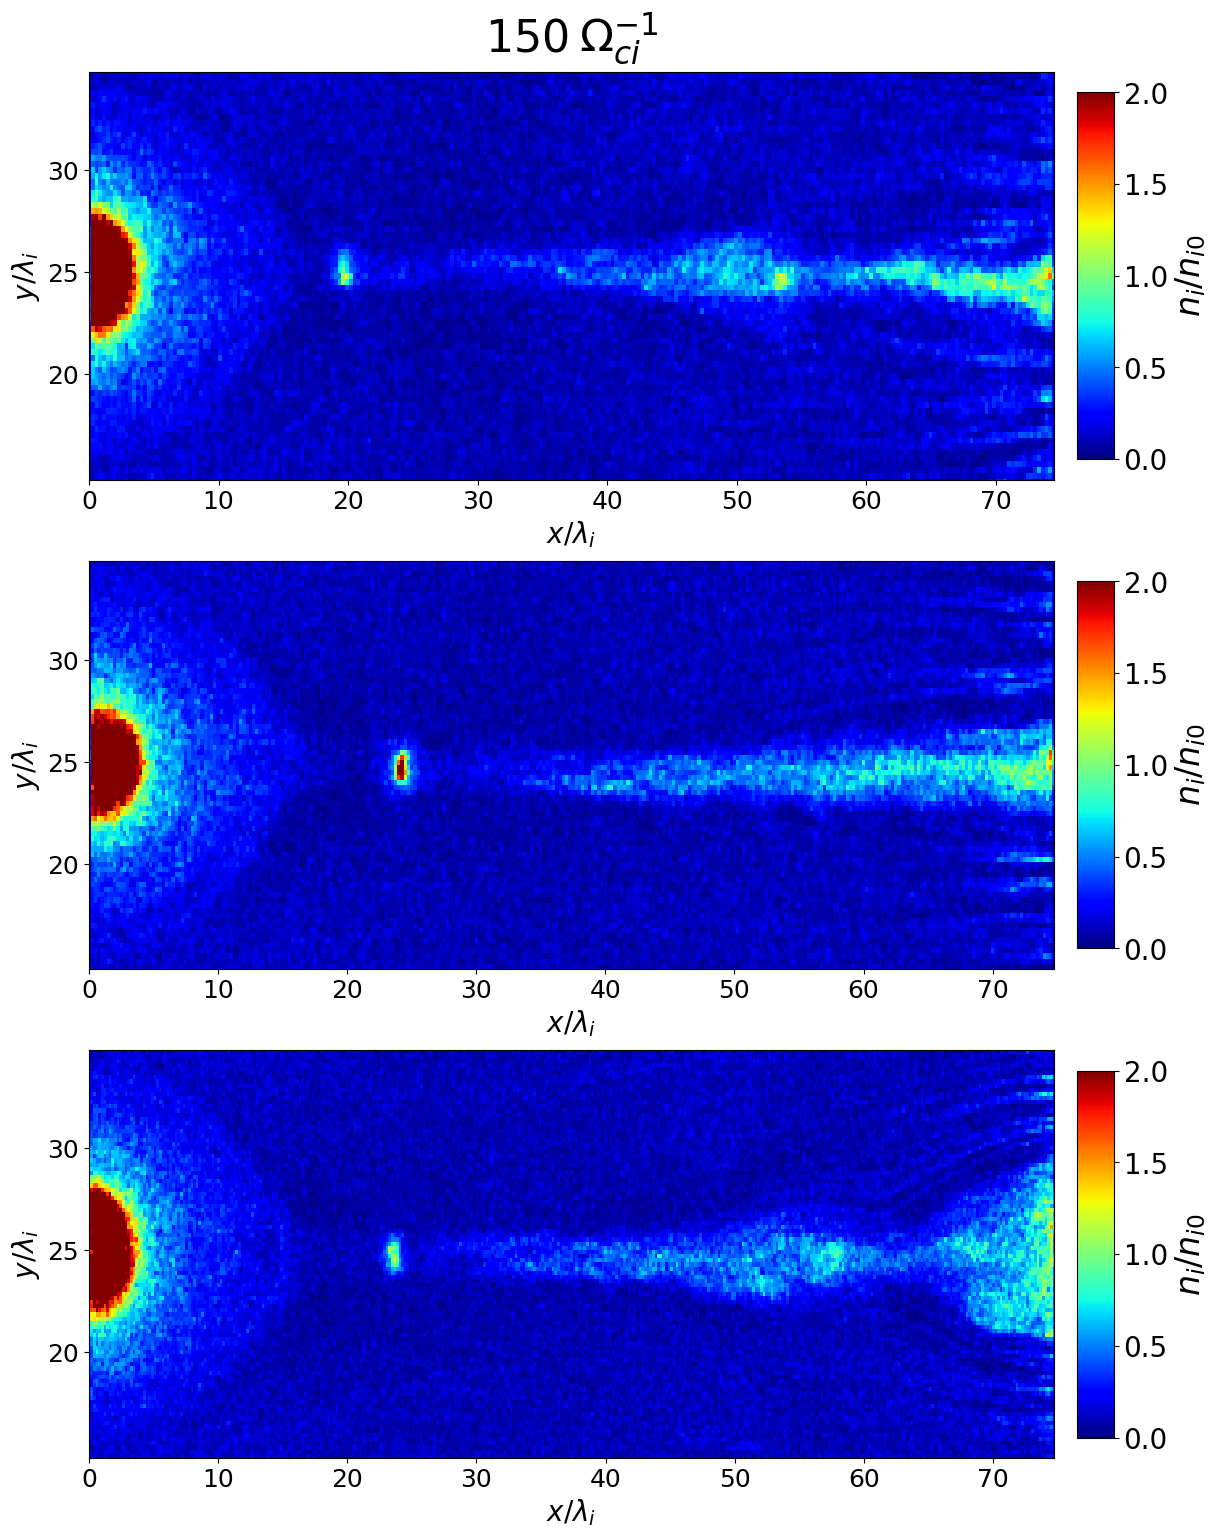

In [19]:
fig = plt.figure(figsize=(15, 18))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

interval = 1
number_of_results = 76
dirname1 = "mr2008_d=0.005_tr=2"
dirname2 = "mr2008_d=0.005_tr=1"
dirname3 = "mr2008_d=0.005_tr=0.5"
filename = "mr2008_d=0.005_ne.mp4"

for k in range(number_of_results):
    ax1.clear()
    ax2.clear()
    ax3.clear()

    t_r = 2.0
    T_i  = (B0**2 / 2.0 / mu_0) / (n_i + n_e * t_r)
    T_e = T_i * t_r
    q_unit = np.sqrt(epsilon0 * T_e / n_e)
    q_electron = -1 * q_unit
    q_ion = r_q * q_unit
    omega_pi = np.sqrt(n_i * q_ion**2 / m_ion / epsilon0)
    omega_ce = q_electron * B0 / m_electron
    omega_ci = q_ion * B0 / m_ion
    ion_inertial_length = c / omega_pi
    n_x = int(ion_inertial_length * 75)
    n_y = int(ion_inertial_length * 50)
    x_min = 0.5 * dx
    y_min = 0.5 * dy
    x_max = n_x * dx - dx
    y_max = n_y * dy - dy
    x_coordinate = np.arange(0.0, x_max+dx, dx)
    y_coordinate = np.arange(0.0, y_max+dy, dy)
    X, Y = np.meshgrid(x_coordinate, y_coordinate) / ion_inertial_length
    zeroth_moment = np.loadtxt(f'{dirname1}/mr2008_zeroth_moment_electron_{k*int(2/omega_ci)}.csv', delimiter=',')[:, 0].reshape(n_x, n_y)
    if k == 0:
        mappable = ax1.pcolormesh(X, Y, zeroth_moment.T / n_i, cmap='jet', vmin=0.0, vmax=2.0)
        cbar = fig.colorbar(mappable, ax=ax1, pad=0.02, shrink=0.9, aspect=10, ticks=np.arange(0.0, 2.1, 0.5))
        cbar.set_label(r'$n_i / n_{i0}$', fontsize=24)
        cbar.ax.tick_params(labelsize=20)
    else:
        ax1.pcolormesh(X, Y, zeroth_moment.T / n_i, cmap='jet', vmin=0.0, vmax=2.0)
    ax1.set_xlabel('$x / \lambda_i$', fontsize=20)
    ax1.set_ylabel('$y / \lambda_i$', fontsize=20)
    ax1.set_xlim(0.0, x_max/ion_inertial_length)
    ax1.set_ylim(y_max/2/ion_inertial_length-10, y_max/2/ion_inertial_length+10)
    ax1.set_xticks([0, 10, 20, 30, 40, 50, 60, 70])
    ax1.set_yticks([20, 25, 30])
    ax1.tick_params(labelsize=18)
    ax1.text(0.5, 1.05, str(2 * k) + r"$ \: \Omega_{ci}^{-1}$", ha='center', transform=ax1.transAxes, fontsize=32)

    t_r = 1.0
    T_i  = (B0**2 / 2.0 / mu_0) / (n_i + n_e * t_r)
    T_e = T_i * t_r
    q_unit = np.sqrt(epsilon0 * T_e / n_e)
    q_electron = -1 * q_unit
    q_ion = r_q * q_unit
    omega_pi = np.sqrt(n_i * q_ion**2 / m_ion / epsilon0)
    omega_ce = q_electron * B0 / m_electron
    omega_ci = q_ion * B0 / m_ion
    ion_inertial_length = c / omega_pi
    n_x = int(ion_inertial_length * 75)
    n_y = int(ion_inertial_length * 50)
    x_min = 0.5 * dx
    y_min = 0.5 * dy
    x_max = n_x * dx - dx
    y_max = n_y * dy - dy
    x_coordinate = np.arange(0.0, x_max+dx, dx)
    y_coordinate = np.arange(0.0, y_max+dy, dy)
    X, Y = np.meshgrid(x_coordinate, y_coordinate) / ion_inertial_length
    zeroth_moment = np.loadtxt(f'{dirname2}/mr2008_zeroth_moment_electron_{k*int(2/omega_ci)}.csv', delimiter=',')[:, 0].reshape(n_x, n_y)
    if k == 0:
        mappable = ax2.pcolormesh(X, Y, zeroth_moment.T / n_i, cmap='jet', vmin=0.0, vmax=2.0)
        cbar = fig.colorbar(mappable, ax=ax2, pad=0.02, shrink=0.9, aspect=10, ticks=np.arange(0.0, 2.1, 0.5))
        cbar.set_label(r'$n_i / n_{i0}$', fontsize=24)
        cbar.ax.tick_params(labelsize=20)
    else:
        ax2.pcolormesh(X, Y, zeroth_moment.T / n_i, cmap='jet', vmin=0.0, vmax=2.0)
    ax2.set_xlabel('$x / \lambda_i$', fontsize=20)
    ax2.set_ylabel('$y / \lambda_i$', fontsize=20)
    ax2.set_xlim(0.0, x_max/ion_inertial_length)
    ax2.set_ylim(y_max/2/ion_inertial_length-10, y_max/2/ion_inertial_length+10)
    ax2.set_xticks([0, 10, 20, 30, 40, 50, 60, 70])
    ax2.set_yticks([20, 25, 30])
    ax2.tick_params(labelsize=18)

    t_r = 0.5
    T_i  = (B0**2 / 2.0 / mu_0) / (n_i + n_e * t_r)
    T_e = T_i * t_r
    q_unit = np.sqrt(epsilon0 * T_e / n_e)
    q_electron = -1 * q_unit
    q_ion = r_q * q_unit
    omega_pi = np.sqrt(n_i * q_ion**2 / m_ion / epsilon0)
    omega_ce = q_electron * B0 / m_electron
    omega_ci = q_ion * B0 / m_ion
    ion_inertial_length = c / omega_pi
    n_x = int(ion_inertial_length * 75)
    n_y = int(ion_inertial_length * 50)
    x_min = 0.5 * dx
    y_min = 0.5 * dy
    x_max = n_x * dx - dx
    y_max = n_y * dy - dy
    x_coordinate = np.arange(0.0, x_max+dx, dx)
    y_coordinate = np.arange(0.0, y_max+dy, dy)
    X, Y = np.meshgrid(x_coordinate, y_coordinate) / ion_inertial_length
    zeroth_moment = np.loadtxt(f'{dirname3}/mr2008_zeroth_moment_electron_{k*int(2/omega_ci)}.csv', delimiter=',')[:, 0].reshape(n_x, n_y)
    if k == 0:
        mappable = ax3.pcolormesh(X, Y, zeroth_moment.T / n_i, cmap='jet', vmin=0.0, vmax=2.0)
        cbar = fig.colorbar(mappable, ax=ax3, pad=0.02, shrink=0.9, aspect=10, ticks=np.arange(0.0, 2.1, 0.5))
        cbar.set_label(r'$n_i / n_{i0}$', fontsize=24)
        cbar.ax.tick_params(labelsize=20)
    else:
        ax3.pcolormesh(X, Y, zeroth_moment.T / n_i, cmap='jet', vmin=0.0, vmax=2.0)
    ax3.set_xlabel('$x / \lambda_i$', fontsize=20)
    ax3.set_ylabel('$y / \lambda_i$', fontsize=20)
    ax3.set_xlim(0.0, x_max/ion_inertial_length)
    ax3.set_ylim(y_max/2/ion_inertial_length-10, y_max/2/ion_inertial_length+10)
    ax3.set_xticks([0, 10, 20, 30, 40, 50, 60, 70])
    ax3.set_yticks([20, 25, 30])
    ax3.tick_params(labelsize=18)

    fig.savefig(f'./pictures/{k}.png', dpi=200)


img = cv2.imread(f'./pictures/0.png')
framesize = (img.shape[1], img.shape[0])
fps = 4.0

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename, fourcc=fourcc, fps=fps, frameSize=framesize)

for i in range(number_of_results):
    img = cv2.imread(f'./pictures/{i}.png')
    video.write(img)
video.release()

### 流速

KeyboardInterrupt: 

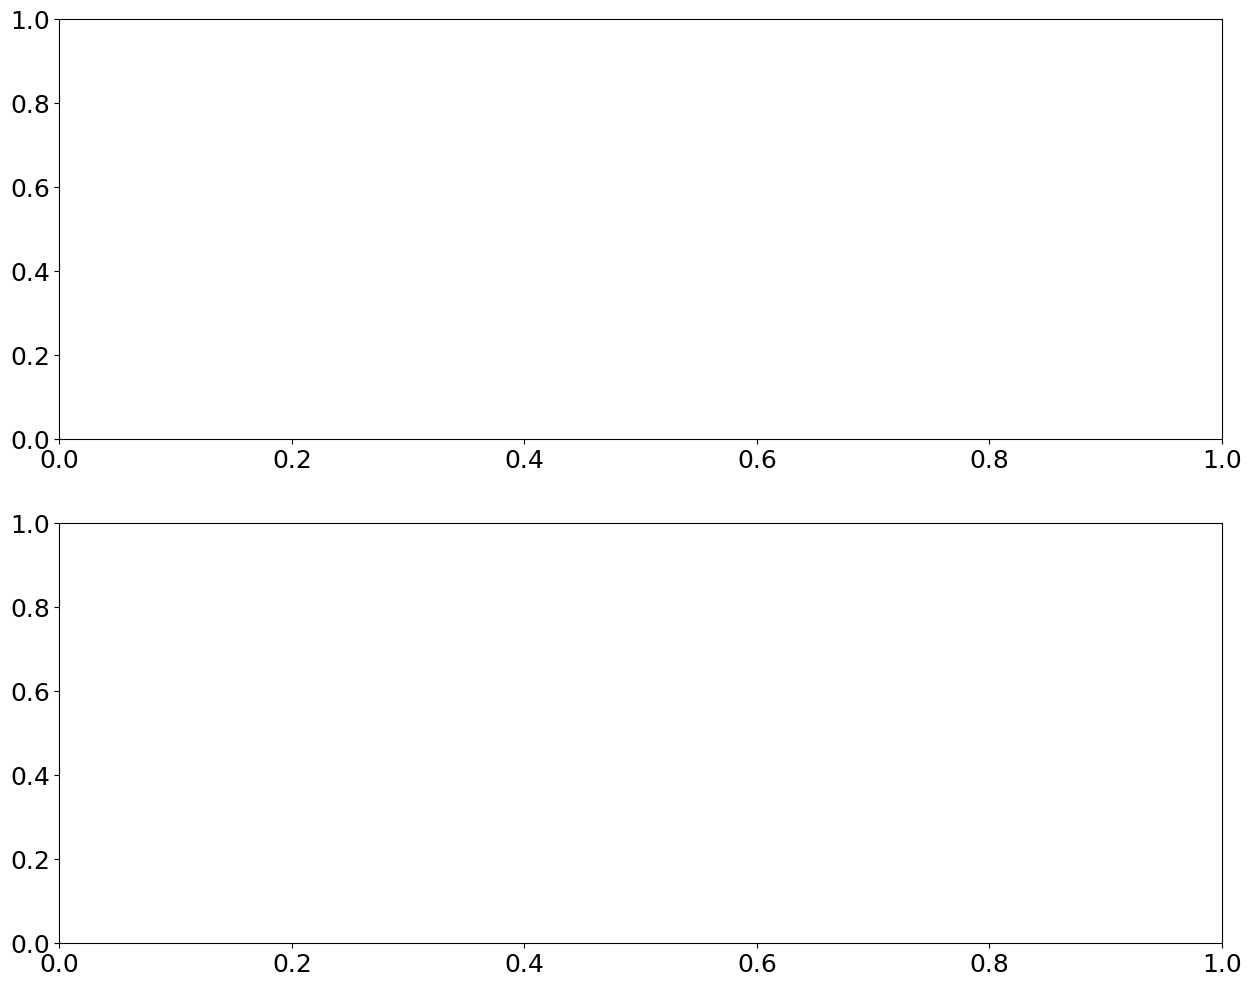

In [4]:
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

X, Y = np.meshgrid(np.arange(n_x), np.arange(n_y))
interval = 1
number_of_results = 16
dirname = "mr2008_tmp"
index1 = 2
index2 = 1
filename1 = "mr2008_tmp_V.mp4"
filename2 = "mr2008_tmp_V_enlarged.mp4"

for k in range(number_of_results):

    zeroth_moment_ion = np.loadtxt(f'{dirname}/mr2008_zeroth_moment_ion_{k*int(10/omega_ci)}.csv', delimiter=',')[:, 0].reshape(n_x, n_y)
    zeroth_moment_electron = np.loadtxt(f'{dirname}/mr2008_zeroth_moment_electron_{k*int(10/omega_ci)}.csv', delimiter=',')[:, 0].reshape(n_x, n_y)
    first_moment_ion = np.loadtxt(f'{dirname}/mr2008_first_moment_ion_{k*int(10/omega_ci)}.csv', delimiter=',')[:, :3].reshape(n_x, n_y, 3)
    first_moment_electron = np.loadtxt(f'{dirname}/mr2008_first_moment_electron_{k*int(10/omega_ci)}.csv', delimiter=',')[:, :3].reshape(n_x, n_y, 3)

    number_density_ion = np.zeros([n_x, n_y])
    number_density_electron = np.zeros([n_x, n_y])
    velocity_average_ion = np.zeros([3, n_x, n_y]) * np.nan
    velocity_average_electron = np.zeros([3, n_x, n_y]) * np.nan
    for i in range(0, int(n_x / index1)):
        for j in range(n_y):
            xmin = int(index1*i*ion_inertial_length)
            xmax = int(index1*(i+1)*ion_inertial_length)
            ymin = int(j*ion_inertial_length)
            ymax = int((j+1)*ion_inertial_length)
            number_density_ion[index1*i, j] = np.mean(zeroth_moment_ion[xmin:xmax, ymin:ymax]) 
            number_density_electron[index1*i, j] = np.mean(zeroth_moment_electron[xmin:xmax, ymin:ymax]) 
            velocity_average_ion[0, index1*i, j] = np.mean(first_moment_ion[xmin:xmax, ymin:ymax, 0]) / (number_density_ion[index1*i, j] + 1e-10)
            velocity_average_ion[1, index1*i, j] = np.mean(first_moment_ion[xmin:xmax, ymin:ymax, 1]) / (number_density_ion[index1*i, j] + 1e-10)
            velocity_average_ion[2, index1*i, j] = np.mean(first_moment_ion[xmin:xmax, ymin:ymax, 2]) / (number_density_ion[index1*i, j] + 1e-10)
            velocity_average_electron[0, index1*i, j] = np.mean(first_moment_electron[xmin:xmax, ymin:ymax, 0]) / (number_density_electron[index1*i, j] + 1e-10)
            velocity_average_electron[1, index1*i, j] = np.mean(first_moment_electron[xmin:xmax, ymin:ymax, 1]) / (number_density_electron[index1*i, j] + 1e-10)
            velocity_average_electron[2, index1*i, j] = np.mean(first_moment_electron[xmin:xmax, ymin:ymax, 2]) / (number_density_electron[index1*i, j] + 1e-10)


    ax1.clear()
    ax2.clear()

    ax1.quiver(X, Y, velocity_average_ion[0].T/V_A, velocity_average_ion[1].T/V_A, scale=30, color='orange')
    ax1.set_xlabel('$x / \lambda_i$', fontsize=20)
    ax1.set_ylabel('$y / \lambda_i$', fontsize=20)
    ax1.set_xlim(0.0, x_max/ion_inertial_length)
    ax1.set_ylim(0.0, y_max/ion_inertial_length)
    ax1.tick_params(labelsize=18)

    ax2.quiver(X, Y, velocity_average_electron[0].T/V_A, velocity_average_electron[1].T/V_A, scale=30, color='blue')
    ax2.set_xlabel('$x / \lambda_i$', fontsize=20)
    ax2.set_ylabel('$y / \lambda_i$', fontsize=20)
    ax2.set_xlim(0.0, x_max/ion_inertial_length)
    ax2.set_ylim(0.0, y_max/ion_inertial_length)
    ax2.tick_params(labelsize=18)

    fig.savefig(f'./pictures/{k}.png', dpi=200)


    ax1.clear()
    ax2.clear()

    number_density_ion = np.zeros([n_x, n_y])
    number_density_electron = np.zeros([n_x, n_y])
    velocity_average_ion = np.zeros([3, n_x, n_y]) * np.nan
    velocity_average_electron = np.zeros([3, n_x, n_y]) * np.nan
    for i in range(0, int(n_x / index2)):
        for j in range(n_y):
            xmin = int(index2*i*ion_inertial_length)
            xmax = int(index2*(i+1)*ion_inertial_length)
            ymin = int(j*ion_inertial_length)
            ymax = int((j+1)*ion_inertial_length)
            number_density_ion[index2*i, j] = np.mean(zeroth_moment_ion[xmin:xmax, ymin:ymax]) 
            number_density_electron[index2*i, j] = np.mean(zeroth_moment_electron[xmin:xmax, ymin:ymax]) 
            velocity_average_ion[0, index2*i, j] = np.mean(first_moment_ion[xmin:xmax, ymin:ymax, 0]) / (number_density_ion[index2*i, j] + 1e-10)
            velocity_average_ion[1, index2*i, j] = np.mean(first_moment_ion[xmin:xmax, ymin:ymax, 1]) / (number_density_ion[index2*i, j] + 1e-10)
            velocity_average_ion[2, index2*i, j] = np.mean(first_moment_ion[xmin:xmax, ymin:ymax, 2]) / (number_density_ion[index2*i, j] + 1e-10)
            velocity_average_electron[0, index2*i, j] = np.mean(first_moment_electron[xmin:xmax, ymin:ymax, 0]) / (number_density_electron[index2*i, j] + 1e-10)
            velocity_average_electron[1, index2*i, j] = np.mean(first_moment_electron[xmin:xmax, ymin:ymax, 1]) / (number_density_electron[index2*i, j] + 1e-10)
            velocity_average_electron[2, index2*i, j] = np.mean(first_moment_electron[xmin:xmax, ymin:ymax, 2]) / (number_density_electron[index2*i, j] + 1e-10)

    ax1.quiver(X, Y, velocity_average_ion[0].T/V_A, velocity_average_ion[1].T/V_A, scale=30, color='orange')
    ax1.set_xlabel('$x / \lambda_i$', fontsize=20)
    ax1.set_ylabel('$y / \lambda_i$', fontsize=20)
    ax1.set_xlim(0.0, x_max/2/ion_inertial_length)
    ax1.set_ylim(y_max/2/ion_inertial_length-10, y_max/2/ion_inertial_length+10)
    ax1.tick_params(labelsize=18)

    ax2.quiver(X, Y, velocity_average_electron[0].T/V_A, velocity_average_electron[1].T/V_A, scale=30, color='blue')
    ax2.set_xlabel('$x / \lambda_i$', fontsize=20)
    ax2.set_ylabel('$y / \lambda_i$', fontsize=20)
    ax2.set_xlim(0.0, x_max/2/ion_inertial_length)
    ax2.set_ylim(y_max/2/ion_inertial_length-10, y_max/2/ion_inertial_length+10)
    ax2.tick_params(labelsize=18)

    fig.savefig(f'./pictures/{k+number_of_results}.png', dpi=200)


img = cv2.imread(f'./pictures/0.png')
framesize = (img.shape[1], img.shape[0])
fps = 2.0

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename1, fourcc=fourcc, fps=fps, frameSize=framesize)
for i in range(number_of_results):
    img = cv2.imread(f'./pictures/{i}.png')
    video.write(img)
video.release()

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename2, fourcc=fourcc, fps=fps, frameSize=framesize)
for i in range(number_of_results):
    img = cv2.imread(f'./pictures/{i+number_of_results}.png')
    video.write(img)
video.release()

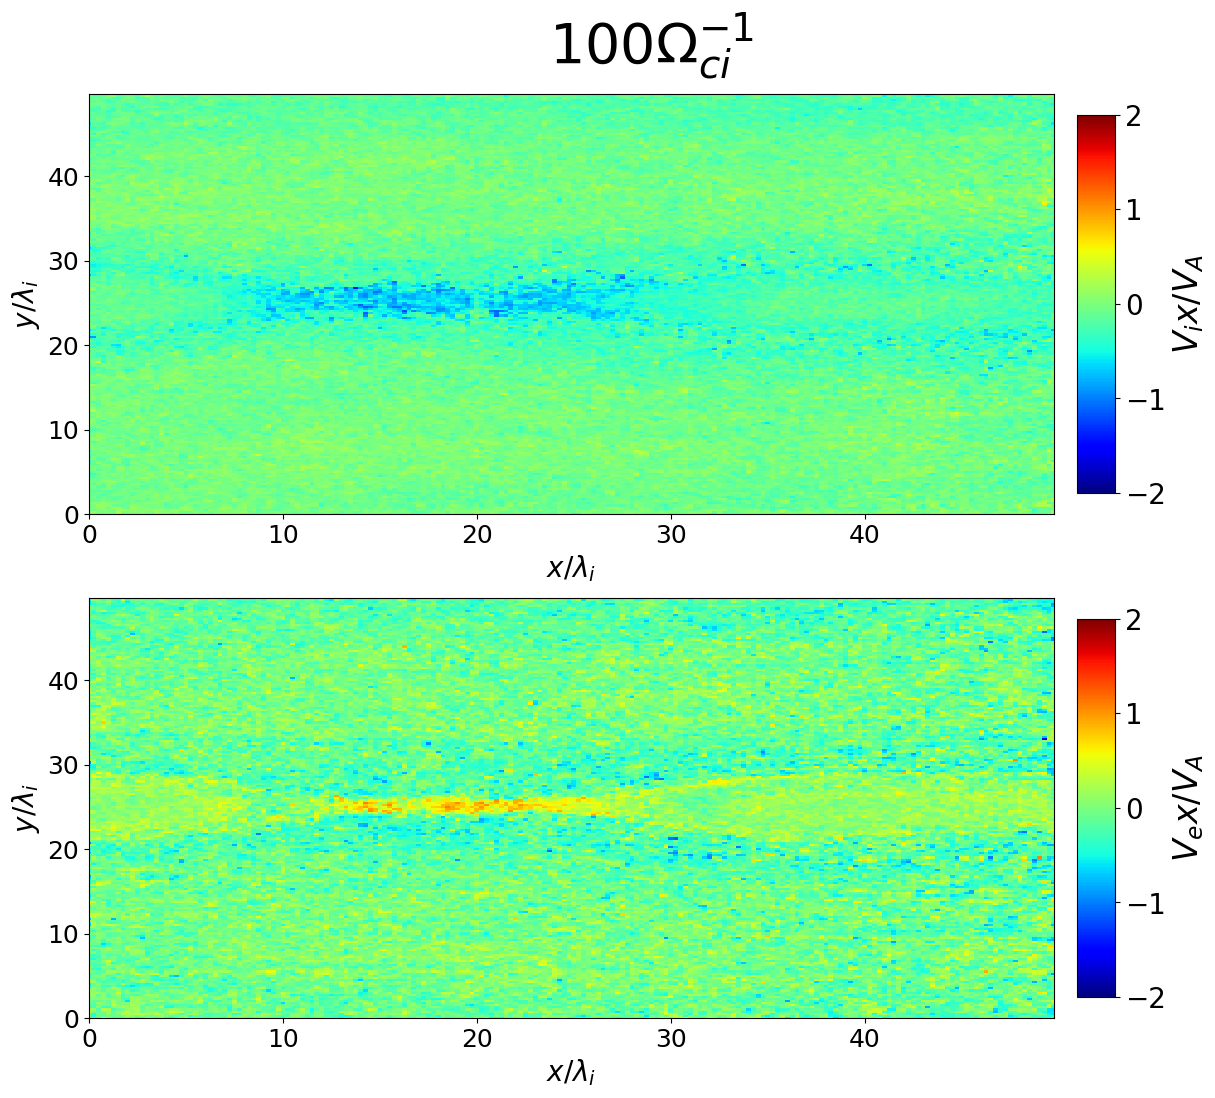

In [9]:
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

X, Y = np.meshgrid(x_coordinate, y_coordinate) / ion_inertial_length
interval = 1
number_of_results = 101
dirname = "mr2008_mr=4_a=2_tr=1"
filename = "mr2008_mr=4_a=2_tr=1_Vz.mp4"

for k in range(number_of_results):

    zeroth_moment_ion = np.loadtxt(f'{dirname}/mr2008_zeroth_moment_ion_{k*int(2/omega_ci)}.csv', delimiter=',')[:, 0].reshape(n_x, n_y)
    zeroth_moment_electron = np.loadtxt(f'{dirname}/mr2008_zeroth_moment_electron_{k*int(2/omega_ci)}.csv', delimiter=',')[:, 0].reshape(n_x, n_y)
    first_moment_ion = np.loadtxt(f'{dirname}/mr2008_first_moment_ion_{k*int(2/omega_ci)}.csv', delimiter=',')[:, :3].reshape(n_x, n_y, 3)
    first_moment_electron = np.loadtxt(f'{dirname}/mr2008_first_moment_electron_{k*int(2/omega_ci)}.csv', delimiter=',')[:, :3].reshape(n_x, n_y, 3)

    velocity_average_ion = np.zeros([3, n_x, n_y])
    velocity_average_electron = np.zeros([3, n_x, n_y])
    velocity_average_ion[0] = first_moment_ion[:, :, 0] / (zeroth_moment_ion[:, :] + 1e-10)
    velocity_average_ion[1] = first_moment_ion[:, :, 1] / (zeroth_moment_ion[:, :] + 1e-10)
    velocity_average_ion[2] = first_moment_ion[:, :, 2] / (zeroth_moment_ion[:, :] + 1e-10)
    velocity_average_electron[0] = first_moment_electron[:, :, 0] / (zeroth_moment_electron[:, :] + 1e-10)
    velocity_average_electron[1] = first_moment_electron[:, :, 1] / (zeroth_moment_electron[:, :] + 1e-10)
    velocity_average_electron[2] = first_moment_electron[:, :, 2] / (zeroth_moment_electron[:, :] + 1e-10)

    ax1.clear()
    ax2.clear()

    if k == 0:
        mappable = ax1.pcolormesh(X, Y, velocity_average_ion[2].T/V_A, vmin=-2.0, vmax=2.0, cmap='jet')
        cbar = fig.colorbar(mappable, ax=ax1, pad=0.02, shrink=0.9, aspect=10, ticks=np.arange(-2.0, 2.1, 1.0))
        cbar.set_label(r'$V_ix / V_A$', fontsize=24)
        cbar.ax.tick_params(labelsize=20)
    else:
        ax1.pcolormesh(X, Y, velocity_average_ion[2].T/V_A, vmin=-2.0, vmax=2.0, cmap='jet')
    ax1.set_xlabel('$x / \lambda_i$', fontsize=20)
    ax1.set_ylabel('$y / \lambda_i$', fontsize=20)
    ax1.set_xlim(0.0, x_max/ion_inertial_length)
    ax1.set_ylim(0.0, y_max/ion_inertial_length)
    ax1.tick_params(labelsize=18)

    if k == 0:
        mappable = ax2.pcolormesh(X, Y, velocity_average_electron[2].T/V_A, vmin=-2.0, vmax=2.0, cmap='jet')
        cbar = fig.colorbar(mappable, ax=ax2, pad=0.02, shrink=0.9, aspect=10, ticks=np.arange(-2.0, 2.1, 1.0))
        cbar.set_label(r'$V_ex / V_A$', fontsize=24)
        cbar.ax.tick_params(labelsize=20)
    else:
        ax2.pcolormesh(X, Y, velocity_average_electron[2].T/V_A, vmin=-2.0, vmax=2.0, cmap='jet')
    ax2.set_xlabel('$x / \lambda_i$', fontsize=20)
    ax2.set_ylabel('$y / \lambda_i$', fontsize=20)
    ax2.set_xlim(0.0, x_max/ion_inertial_length)
    ax2.set_ylim(0.0, y_max/ion_inertial_length)
    ax2.tick_params(labelsize=18)

    fig.suptitle(f"{2*k}" + r"$\Omega_{ci}^{-1}$", x=0.5, y=0.95, fontsize=40)

    fig.savefig(f'./pictures/{k}.png', dpi=200)


img = cv2.imread(f'./pictures/0.png')
framesize = (img.shape[1], img.shape[0])
fps = 4.0

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename, fourcc=fourcc, fps=fps, frameSize=framesize)
for i in range(number_of_results):
    img = cv2.imread(f'./pictures/{i}.png')
    video.write(img)
video.release()

### 温度

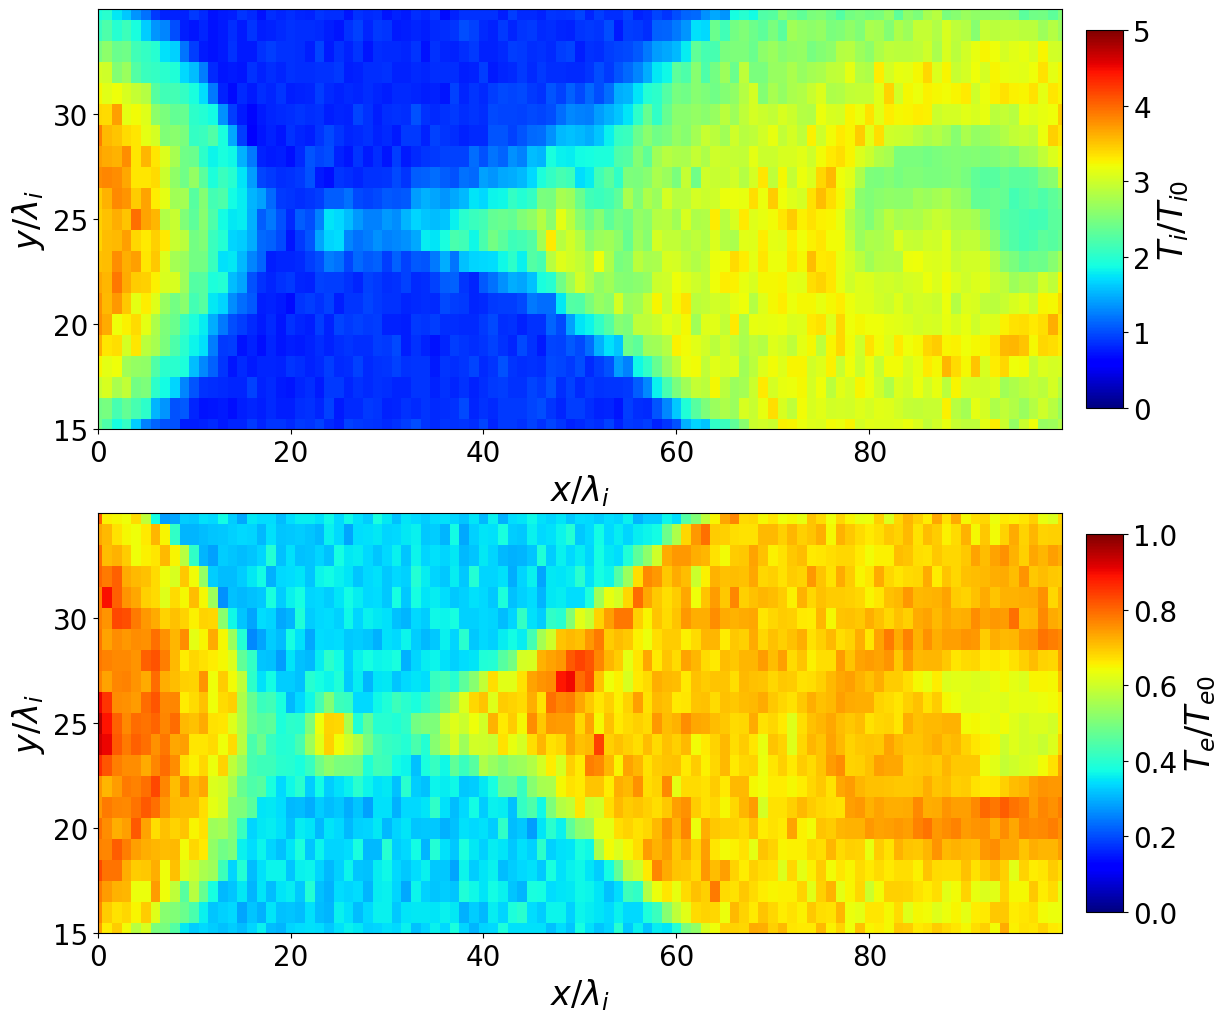

In [52]:
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

X, Y = np.meshgrid(np.arange(200), np.arange(50))
interval = 1
number_of_results = 11
dirname = "mr2008_sg_tr2"
filename1 = "mr2008_sg_tr2_Tx.mp4"
filename2 = "mr2008_sg_tr2_Tx_enlarged.mp4"
filename3 = "mr2008_sg_tr2_Ty.mp4"
filename4 = "mr2008_sg_tr2_Ty_enlarged.mp4"

for k in range(number_of_results):

    zeroth_order_ion = np.load(f'{dirname}/mr2008_zeroth_order_ion_{k*5000}.npy') + 1e-10
    zeroth_order_electron = np.load(f'{dirname}/mr2008_zeroth_order_electron_{k*5000}.npy') + 1e-10
    first_order_ion = np.load(f'{dirname}/mr2008_first_order_ion_{k*5000}.npy')
    first_order_electron = np.load(f'{dirname}/mr2008_first_order_electron_{k*5000}.npy')
    second_order_ion = np.load(f'{dirname}/mr2008_second_order_ion_{k*5000}.npy')
    second_order_electron = np.load(f'{dirname}/mr2008_second_order_electron_{k*5000}.npy')

    number_density_ion = np.zeros([200, 50])
    number_density_electron = np.zeros([200, 50])
    velocity_average_ion = np.zeros([3, 200, 50])
    velocity_average_electron = np.zeros([3, 200, 50])
    temperature_average_ion = np.zeros([3, 3, 200, 50])
    temperature_average_electron = np.zeros([3, 3, 200, 50])
    for i in range(200):
        for j in range(50):
            xmin = int(i*ion_inertial_length)
            xmax = int((i+1)*ion_inertial_length)
            ymin = int(j*ion_inertial_length)
            ymax = int((j+1)*ion_inertial_length)
            number_density_ion[i, j] = np.mean(zeroth_order_ion[xmin:xmax, ymin:ymax]) 
            number_density_electron[i, j] = np.mean(zeroth_order_electron[xmin:xmax, ymin:ymax]) 
            velocity_average_ion[0, i, j] = np.mean(first_order_ion[0, xmin:xmax, ymin:ymax]) / (number_density_ion[i, j] + 1e-10)
            velocity_average_ion[1, i, j] = np.mean(first_order_ion[1, xmin:xmax, ymin:ymax]) / (number_density_ion[i, j] + 1e-10)
            velocity_average_ion[2, i, j] = np.mean(first_order_ion[2, xmin:xmax, ymin:ymax]) / (number_density_ion[i, j] + 1e-10)
            velocity_average_electron[0, i, j] = np.mean(first_order_electron[0, xmin:xmax, ymin:ymax]) / (number_density_electron[i, j] + 1e-10)
            velocity_average_electron[1, i, j] = np.mean(first_order_electron[1, xmin:xmax, ymin:ymax]) / (number_density_electron[i, j] + 1e-10)
            velocity_average_electron[2, i, j] = np.mean(first_order_electron[2, xmin:xmax, ymin:ymax]) / (number_density_electron[i, j] + 1e-10)

            temperature_average_ion[0, 0, i, j] = np.mean(second_order_ion[0, 0, xmin:xmax, ymin:ymax]) / (number_density_ion[i, j] + 1e-10) - velocity_average_ion[0, i, j]**2
            temperature_average_ion[1, 1, i, j] = np.mean(second_order_ion[1, 1, xmin:xmax, ymin:ymax]) / (number_density_ion[i, j] + 1e-10) - velocity_average_ion[1, i, j]**2
            temperature_average_ion[2, 2, i, j] = np.mean(second_order_ion[2, 2, xmin:xmax, ymin:ymax]) / (number_density_ion[i, j] + 1e-10) - velocity_average_ion[2, i, j]**2
            temperature_average_electron[0, 0, i, j] = np.mean(second_order_electron[0, 0, xmin:xmax, ymin:ymax]) / (number_density_electron[i, j] + 1e-10) - velocity_average_electron[0, i, j]**2
            temperature_average_electron[1, 1, i, j] = np.mean(second_order_electron[1, 1, xmin:xmax, ymin:ymax]) / (number_density_electron[i, j] + 1e-10) - velocity_average_electron[1, i, j]**2
            temperature_average_electron[2, 2, i, j] = np.mean(second_order_electron[2, 2, xmin:xmax, ymin:ymax]) / (number_density_electron[i, j] + 1e-10) - velocity_average_electron[2, i, j]**2


    ax1.clear()
    ax2.clear()
    
    if k == 0:
        mappable = ax1.pcolormesh(X, Y, m_ion * temperature_average_ion[0, 0, :, :].T / T_i, cmap='jet', vmin=0.0, vmax=5.0)
        cbar = fig.colorbar(mappable, ax=ax1, pad=0.02, shrink=0.9, aspect=10, ticks=np.arange(0.0, 5.1, 1.0))
        cbar.set_label(r'$T_i / T_{i0}$', fontsize=24)
        cbar.ax.tick_params(labelsize=20)
    else:
        ax1.pcolormesh(X, Y, m_ion * temperature_average_ion[0, 0, :, :].T / T_i, cmap='jet', vmin=0.0, vmax=5.0)

    ax1.set_xlabel('$x / \lambda_i$', fontsize=24)
    ax1.set_ylabel('$y / \lambda_i$', fontsize=24)
    ax1.set_xlim(0.0, x_max/ion_inertial_length)
    ax1.set_ylim(0.0, y_max/ion_inertial_length)
    ax1.tick_params(labelsize=20)

    if k == 0:
        mappable = ax2.pcolormesh(X, Y, m_electron * temperature_average_electron[0, 0, :, :].T / T_e, cmap='jet', vmin=0.0, vmax=1.0)
        cbar = fig.colorbar(mappable, ax=ax2, pad=0.02, shrink=0.9, aspect=10, ticks=np.arange(0.0, 1.1, 0.2))
        cbar.set_label(r'$T_e / T_{e0}$', fontsize=24)
        cbar.ax.tick_params(labelsize=20)
    else:
        ax2.pcolormesh(X, Y, m_electron * temperature_average_electron[0, 0, :, :].T / T_e, cmap='jet', vmin=0.0, vmax=1.0)

    ax2.set_xlabel('$x / \lambda_i$', fontsize=24)
    ax2.set_ylabel('$y / \lambda_i$', fontsize=24)
    ax2.set_xlim(0.0, x_max/ion_inertial_length)
    ax2.set_ylim(0.0, y_max/ion_inertial_length)
    ax2.tick_params(labelsize=20)

    fig.savefig(f'./pictures/{k}.png', dpi=200)

    ax1.set_xlim(0.0, x_max/2/ion_inertial_length)
    ax1.set_ylim(y_max/2/ion_inertial_length-10, y_max/2/ion_inertial_length+10)
    ax2.set_xlim(0.0, x_max/2/ion_inertial_length)
    ax2.set_ylim(y_max/2/ion_inertial_length-10, y_max/2/ion_inertial_length+10)

    fig.savefig(f'./pictures/{k+number_of_results}.png', dpi=200)

    ##############################################

    ax1.clear()
    ax2.clear()

    ax1.pcolormesh(X, Y, m_ion * temperature_average_ion[1, 1, :, :].T / T_i, cmap='jet', vmin=0.0, vmax=5.0)
    ax1.set_xlabel('$x / \lambda_i$', fontsize=24)
    ax1.set_ylabel('$y / \lambda_i$', fontsize=24)
    ax1.set_xlim(0.0, x_max/ion_inertial_length)
    ax1.set_ylim(0.0, y_max/ion_inertial_length)
    ax1.tick_params(labelsize=20)

    ax2.pcolormesh(X, Y, m_electron * temperature_average_electron[1, 1, :, :].T / T_e, cmap='jet', vmin=0.0, vmax=1.0)
    ax2.set_xlabel('$x / \lambda_i$', fontsize=24)
    ax2.set_ylabel('$y / \lambda_i$', fontsize=24)
    ax2.set_xlim(0.0, x_max/ion_inertial_length)
    ax2.set_ylim(0.0, y_max/ion_inertial_length)
    ax2.tick_params(labelsize=20)

    fig.savefig(f'./pictures/{k+2*number_of_results}.png', dpi=200)

    ax1.set_xlim(0.0, x_max/2/ion_inertial_length)
    ax1.set_ylim(y_max/2/ion_inertial_length-10, y_max/2/ion_inertial_length+10)
    ax2.set_xlim(0.0, x_max/2/ion_inertial_length)
    ax2.set_ylim(y_max/2/ion_inertial_length-10, y_max/2/ion_inertial_length+10)

    fig.savefig(f'./pictures/{k+3*number_of_results}.png', dpi=200)


img = cv2.imread(f'./pictures/0.png')
framesize = (img.shape[1], img.shape[0])
fps = 1.0

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename1, fourcc=fourcc, fps=fps, frameSize=framesize)
for i in range(number_of_results):
    img = cv2.imread(f'./pictures/{i}.png')
    video.write(img)
video.release()

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename2, fourcc=fourcc, fps=fps, frameSize=framesize)
for i in range(number_of_results):
    img = cv2.imread(f'./pictures/{i+number_of_results}.png')
    video.write(img)
video.release()

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename3, fourcc=fourcc, fps=fps, frameSize=framesize)
for i in range(number_of_results):
    img = cv2.imread(f'./pictures/{i+2*number_of_results}.png')
    video.write(img)
video.release()

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename4, fourcc=fourcc, fps=fps, frameSize=framesize)
for i in range(number_of_results):
    img = cv2.imread(f'./pictures/{i+3*number_of_results}.png')
    video.write(img)
video.release()

---

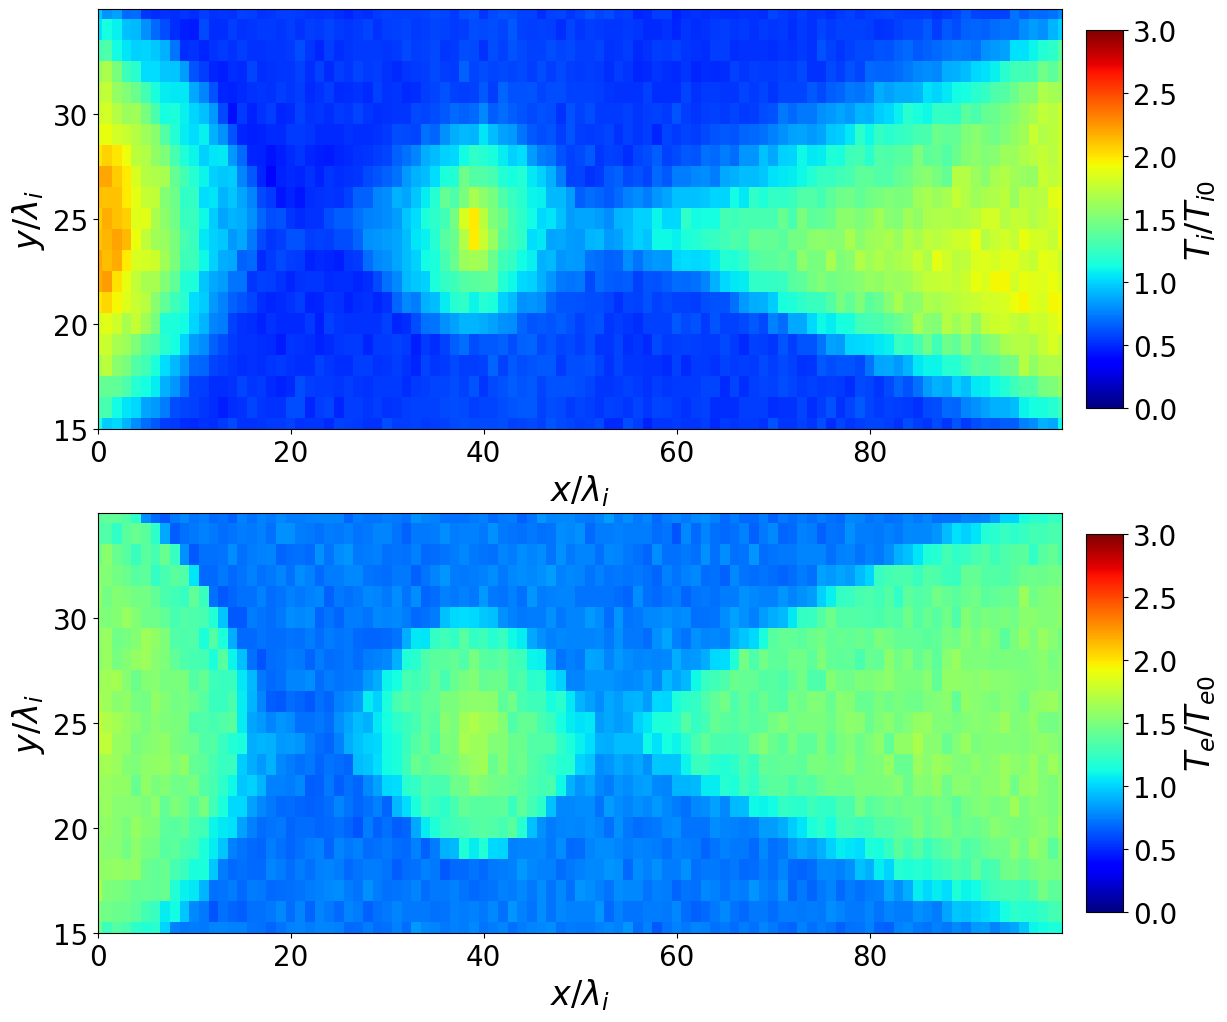

In [58]:
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

X, Y = np.meshgrid(np.arange(200), np.arange(50))
interval = 1
number_of_results = 15
dirname = "mr2008_sg_tr0.5"
filename1 = "mr2008_sg_tr0.5_Tx.mp4"
filename2 = "mr2008_sg_tr0.5_Tx_enlarged.mp4"
filename3 = "mr2008_sg_tr0.5_Ty.mp4"
filename4 = "mr2008_sg_tr0.5_Ty_enlarged.mp4"

for k in range(number_of_results):

    zeroth_order_ion = np.load(f'{dirname}/mr2008_zeroth_order_ion_{k*5000}.npy') + 1e-10
    zeroth_order_electron = np.load(f'{dirname}/mr2008_zeroth_order_electron_{k*5000}.npy') + 1e-10
    first_order_ion = np.load(f'{dirname}/mr2008_first_order_ion_{k*5000}.npy')
    first_order_electron = np.load(f'{dirname}/mr2008_first_order_electron_{k*5000}.npy')
    second_order_ion = np.load(f'{dirname}/mr2008_second_order_ion_{k*5000}.npy')
    second_order_electron = np.load(f'{dirname}/mr2008_second_order_electron_{k*5000}.npy')

    temperature_average_ion = np.zeros([3, 3, 200, 50])
    temperature_average_electron = np.zeros([3, 3, 200, 50])
    number_density_ion = np.zeros([200, 50])
    number_density_electron = np.zeros([200, 50])
    velocity_average_ion = np.zeros([3, 200, 50])
    velocity_average_electron = np.zeros([3, 200, 50])
    temperature_average_ion = np.zeros([3, 3, 200, 50])
    temperature_average_electron = np.zeros([3, 3, 200, 50])
    for i in range(200):
        for j in range(50):
            xmin = int(i*ion_inertial_length)
            xmax = int((i+1)*ion_inertial_length)
            ymin = int(j*ion_inertial_length)
            ymax = int((j+1)*ion_inertial_length)
            number_density_ion[i, j] = np.mean(zeroth_order_ion[xmin:xmax, ymin:ymax]) 
            number_density_electron[i, j] = np.mean(zeroth_order_electron[xmin:xmax, ymin:ymax]) 
            velocity_average_ion[0, i, j] = np.mean(first_order_ion[0, xmin:xmax, ymin:ymax]) / (number_density_ion[i, j] + 1e-10)
            velocity_average_ion[1, i, j] = np.mean(first_order_ion[1, xmin:xmax, ymin:ymax]) / (number_density_ion[i, j] + 1e-10)
            velocity_average_ion[2, i, j] = np.mean(first_order_ion[2, xmin:xmax, ymin:ymax]) / (number_density_ion[i, j] + 1e-10)
            velocity_average_electron[0, i, j] = np.mean(first_order_electron[0, xmin:xmax, ymin:ymax]) / (number_density_electron[i, j] + 1e-10)
            velocity_average_electron[1, i, j] = np.mean(first_order_electron[1, xmin:xmax, ymin:ymax]) / (number_density_electron[i, j] + 1e-10)
            velocity_average_electron[2, i, j] = np.mean(first_order_electron[2, xmin:xmax, ymin:ymax]) / (number_density_electron[i, j] + 1e-10)

            temperature_average_ion[0, 0, i, j] = np.mean(second_order_ion[0, 0, xmin:xmax, ymin:ymax]) / (number_density_ion[i, j] + 1e-10) - velocity_average_ion[0, i, j]**2
            temperature_average_ion[1, 1, i, j] = np.mean(second_order_ion[1, 1, xmin:xmax, ymin:ymax]) / (number_density_ion[i, j] + 1e-10) - velocity_average_ion[1, i, j]**2
            temperature_average_ion[2, 2, i, j] = np.mean(second_order_ion[2, 2, xmin:xmax, ymin:ymax]) / (number_density_ion[i, j] + 1e-10) - velocity_average_ion[2, i, j]**2
            temperature_average_electron[0, 0, i, j] = np.mean(second_order_electron[0, 0, xmin:xmax, ymin:ymax]) / (number_density_electron[i, j] + 1e-10) - velocity_average_electron[0, i, j]**2
            temperature_average_electron[1, 1, i, j] = np.mean(second_order_electron[1, 1, xmin:xmax, ymin:ymax]) / (number_density_electron[i, j] + 1e-10) - velocity_average_electron[1, i, j]**2
            temperature_average_electron[2, 2, i, j] = np.mean(second_order_electron[2, 2, xmin:xmax, ymin:ymax]) / (number_density_electron[i, j] + 1e-10) - velocity_average_electron[2, i, j]**2


    ax1.clear()
    ax2.clear()
    
    if k == 0:
        mappable = ax1.pcolormesh(X, Y, m_ion * temperature_average_ion[0, 0, :, :].T / T_i, cmap='jet', vmin=0.0, vmax=3.0)
        cbar = fig.colorbar(mappable, ax=ax1, pad=0.02, shrink=0.9, aspect=10, ticks=np.arange(0.0, 3.1, 0.5))
        cbar.set_label(r'$T_i / T_{i0}$', fontsize=24)
        cbar.ax.tick_params(labelsize=20)
    else:
        ax1.pcolormesh(X, Y, m_ion * temperature_average_ion[0, 0, :, :].T / T_i, cmap='jet', vmin=0.0, vmax=3.0)

    ax1.set_xlabel('$x / \lambda_i$', fontsize=24)
    ax1.set_ylabel('$y / \lambda_i$', fontsize=24)
    ax1.set_xlim(0.0, x_max/ion_inertial_length)
    ax1.set_ylim(0.0, y_max/ion_inertial_length)
    ax1.tick_params(labelsize=20)

    if k == 0:
        mappable = ax2.pcolormesh(X, Y, m_electron * temperature_average_electron[0, 0, :, :].T / T_e, cmap='jet', vmin=0.0, vmax=3.0)
        cbar = fig.colorbar(mappable, ax=ax2, pad=0.02, shrink=0.9, aspect=10, ticks=np.arange(0.0, 3.1, 0.5))
        cbar.set_label(r'$T_e / T_{e0}$', fontsize=24)
        cbar.ax.tick_params(labelsize=20)
    else:
        ax2.pcolormesh(X, Y, m_electron * temperature_average_electron[0, 0, :, :].T / T_e, cmap='jet', vmin=0.0, vmax=3.0)

    ax2.set_xlabel('$x / \lambda_i$', fontsize=24)
    ax2.set_ylabel('$y / \lambda_i$', fontsize=24)
    ax2.set_xlim(0.0, x_max/ion_inertial_length)
    ax2.set_ylim(0.0, y_max/ion_inertial_length)
    ax2.tick_params(labelsize=20)

    fig.savefig(f'./pictures/{k}.png', dpi=200)

    ax1.set_xlim(0.0, x_max/2/ion_inertial_length)
    ax1.set_ylim(y_max/2/ion_inertial_length-10, y_max/2/ion_inertial_length+10)
    ax2.set_xlim(0.0, x_max/2/ion_inertial_length)
    ax2.set_ylim(y_max/2/ion_inertial_length-10, y_max/2/ion_inertial_length+10)

    fig.savefig(f'./pictures/{k+number_of_results}.png', dpi=200)

    ##############################################

    ax1.clear()
    ax2.clear()

    ax1.pcolormesh(X, Y, m_ion * temperature_average_ion[1, 1, :, :].T / T_i, cmap='jet', vmin=0.0, vmax=3.0)
    ax1.set_xlabel('$x / \lambda_i$', fontsize=24)
    ax1.set_ylabel('$y / \lambda_i$', fontsize=24)
    ax1.set_xlim(0.0, x_max/ion_inertial_length)
    ax1.set_ylim(0.0, y_max/ion_inertial_length)
    ax1.tick_params(labelsize=20)

    ax2.pcolormesh(X, Y, m_electron * temperature_average_electron[1, 1, :, :].T / T_e, cmap='jet', vmin=0.0, vmax=3.0)
    ax2.set_xlabel('$x / \lambda_i$', fontsize=24)
    ax2.set_ylabel('$y / \lambda_i$', fontsize=24)
    ax2.set_xlim(0.0, x_max/ion_inertial_length)
    ax2.set_ylim(0.0, y_max/ion_inertial_length)
    ax2.tick_params(labelsize=20)

    fig.savefig(f'./pictures/{k+2*number_of_results}.png', dpi=200)

    ax1.set_xlim(0.0, x_max/2/ion_inertial_length)
    ax1.set_ylim(y_max/2/ion_inertial_length-10, y_max/2/ion_inertial_length+10)
    ax2.set_xlim(0.0, x_max/2/ion_inertial_length)
    ax2.set_ylim(y_max/2/ion_inertial_length-10, y_max/2/ion_inertial_length+10)

    fig.savefig(f'./pictures/{k+3*number_of_results}.png', dpi=200)


img = cv2.imread(f'./pictures/0.png')
framesize = (img.shape[1], img.shape[0])
fps = 1.0

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename1, fourcc=fourcc, fps=fps, frameSize=framesize)
for i in range(number_of_results):
    img = cv2.imread(f'./pictures/{i}.png')
    video.write(img)
video.release()

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename2, fourcc=fourcc, fps=fps, frameSize=framesize)
for i in range(number_of_results):
    img = cv2.imread(f'./pictures/{i+number_of_results}.png')
    video.write(img)
video.release()

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename3, fourcc=fourcc, fps=fps, frameSize=framesize)
for i in range(number_of_results):
    img = cv2.imread(f'./pictures/{i+2*number_of_results}.png')
    video.write(img)
video.release()

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename4, fourcc=fourcc, fps=fps, frameSize=framesize)
for i in range(number_of_results):
    img = cv2.imread(f'./pictures/{i+3*number_of_results}.png')
    video.write(img)
video.release()

### 電子電流

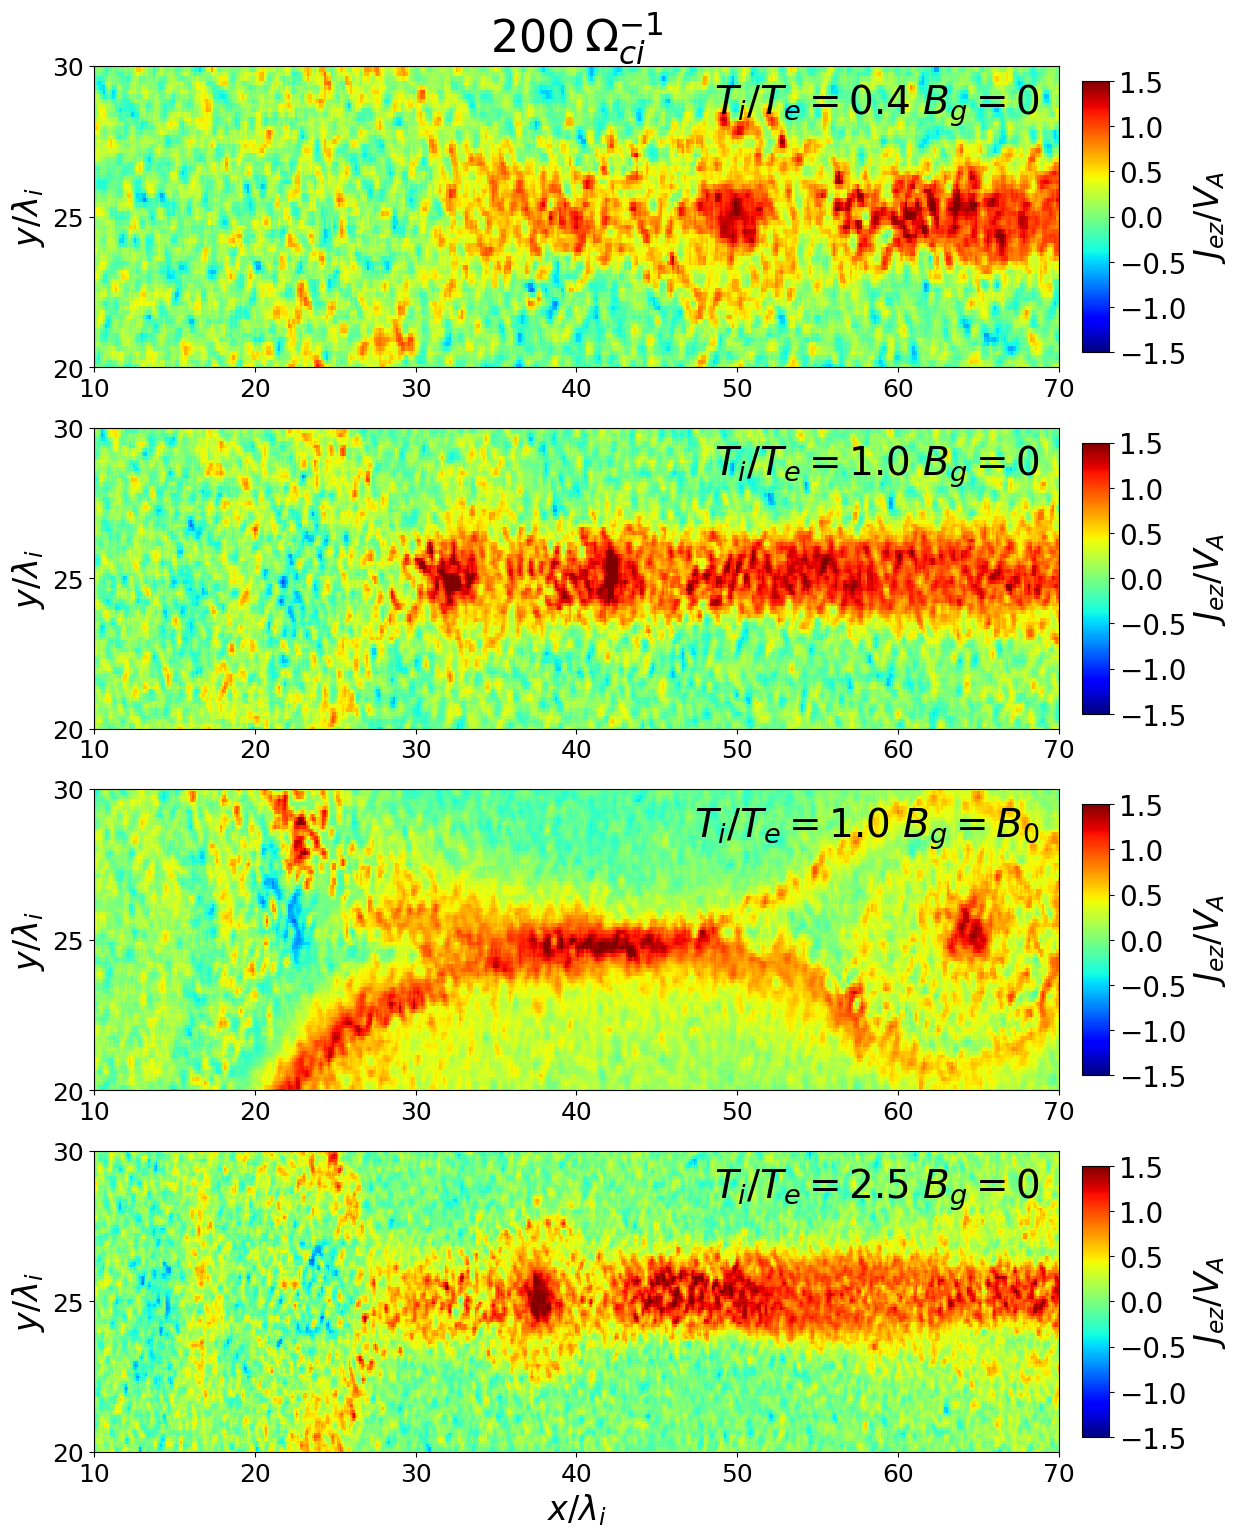

In [52]:
fig = plt.figure(figsize=(15, 18))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

interval = 1
number_of_results = 101
dirname1 = "mr2008_mr=4_a=2_tr=2.5"
dirname2 = "mr2008_mr=4_a=2_tr=1"
dirname3 = "mr2008_mr=4_a=2_tr=1_g"
dirname4 = "mr2008_mr=4_a=2_tr=0.4"
filename = "mr2008_jez.mp4"

for k in range(number_of_results):
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()

    t_r = 2.5
    T_i  = (B0**2 / 2.0 / mu_0) / (n_i + n_e * t_r)
    T_e = T_i * t_r
    q_unit = np.sqrt(epsilon0 * T_e / n_e)
    q_electron = -1 * q_unit
    q_ion = r_q * q_unit
    omega_pi = np.sqrt(n_i * q_ion**2 / m_ion / epsilon0)
    omega_ce = q_electron * B0 / m_electron
    omega_ci = q_ion * B0 / m_ion
    ion_inertial_length = c / omega_pi
    V_A = B0 / np.sqrt(mu_0 * n_i * m_ion)
    n_x = int(ion_inertial_length * 100)
    n_y = int(ion_inertial_length * 50)
    x_min = 0.5 * dx
    y_min = 0.5 * dy
    x_max = n_x * dx - dx
    y_max = n_y * dy - dy
    x_coordinate = np.arange(0.0, x_max+dx, dx)
    y_coordinate = np.arange(0.0, y_max+dy, dy)
    X, Y = np.meshgrid(x_coordinate, y_coordinate) / ion_inertial_length
    zeroth_moment = np.loadtxt(f'{dirname1}/mr2008_zeroth_moment_electron_{k*int(2/omega_ci)}.csv', delimiter=',')[:, 0].reshape(n_x, n_y)
    first_moment = np.loadtxt(f'{dirname1}/mr2008_first_moment_electron_{k*int(2/omega_ci)}.csv', delimiter=',')[:, 0:3].reshape(n_x, n_y, 3)
    current_ez = first_moment[:, :, 2] / (zeroth_moment + 1e-10)
    if k == 0:
        mappable = ax1.pcolormesh(X, Y, cv2.blur(current_ez.T / V_A, (3, 3)), cmap='jet', vmin=-1.5, vmax=1.5)
        cbar = fig.colorbar(mappable, ax=ax1, pad=0.02, shrink=0.9, aspect=10, ticks=np.arange(-1.5, 1.6, 0.5))
        cbar.set_label(r'$J_{ez} / V_A$', fontsize=24)
        cbar.ax.tick_params(labelsize=20)
    else:
        ax1.pcolormesh(X, Y, cv2.blur(current_ez.T / V_A, (3, 3)), cmap='jet', vmin=-1.5, vmax=1.5)
    ax1.set_ylabel('$y / \lambda_i$', fontsize=24)
    ax1.set_xlim(10, 70)
    ax1.set_ylim(20, 30)
    ax1.set_xticks([10, 20, 30, 40, 50, 60, 70])
    ax1.set_yticks([20, 25, 30])
    ax1.tick_params(labelsize=18)
    ax1.text(0.5, 1.05, str(2 * k) + r"$ \: \Omega_{ci}^{-1}$", ha='center', transform=ax1.transAxes, fontsize=32)
    ax1.text(0.98, 0.95, r"$T_i / T_e = $" + str(round(1/t_r, 1)) + " " + r"$B_g = 0$", va='top', ha='right', transform=ax1.transAxes, fontsize=28)

    t_r = 1.0
    T_i  = (B0**2 / 2.0 / mu_0) / (n_i + n_e * t_r)
    T_e = T_i * t_r
    q_unit = np.sqrt(epsilon0 * T_e / n_e)
    q_electron = -1 * q_unit
    q_ion = r_q * q_unit
    omega_pi = np.sqrt(n_i * q_ion**2 / m_ion / epsilon0)
    omega_ce = q_electron * B0 / m_electron
    omega_ci = q_ion * B0 / m_ion
    ion_inertial_length = c / omega_pi
    V_A = B0 / np.sqrt(mu_0 * n_i * m_ion)
    n_x = int(ion_inertial_length * 100)
    n_y = int(ion_inertial_length * 50)
    x_min = 0.5 * dx
    y_min = 0.5 * dy
    x_max = n_x * dx - dx
    y_max = n_y * dy - dy
    x_coordinate = np.arange(0.0, x_max+dx, dx)
    y_coordinate = np.arange(0.0, y_max+dy, dy)
    X, Y = np.meshgrid(x_coordinate, y_coordinate) / ion_inertial_length
    zeroth_moment = np.loadtxt(f'{dirname2}/mr2008_zeroth_moment_electron_{k*int(2/omega_ci)}.csv', delimiter=',')[:, 0].reshape(n_x, n_y)
    first_moment = np.loadtxt(f'{dirname2}/mr2008_first_moment_electron_{k*int(2/omega_ci)}.csv', delimiter=',')[:, 0:3].reshape(n_x, n_y, 3)
    current_ez = first_moment[:, :, 2] / (zeroth_moment + 1e-10)
    if k == 0:
        mappable = ax2.pcolormesh(X, Y, cv2.blur(current_ez.T / V_A, (3, 3)), cmap='jet', vmin=-1.5, vmax=1.5)
        cbar = fig.colorbar(mappable, ax=ax2, pad=0.02, shrink=0.9, aspect=10, ticks=np.arange(-1.5, 1.6, 0.5))
        cbar.set_label(r'$J_{ez} / V_A$', fontsize=24)
        cbar.ax.tick_params(labelsize=20)
    else:
        ax2.pcolormesh(X, Y, cv2.blur(current_ez.T / V_A, (3, 3)), cmap='jet', vmin=-1.5, vmax=1.5)
    ax2.set_ylabel('$y / \lambda_i$', fontsize=24)
    ax2.set_xlim(10, 70)
    ax2.set_ylim(20, 30)
    ax2.set_xticks([10, 20, 30, 40, 50, 60, 70])
    ax2.set_yticks([20, 25, 30])
    ax2.tick_params(labelsize=18)
    ax2.text(0.98, 0.95, r"$T_i / T_e = $" + str(round(1/t_r, 1)) + " " + r"$B_g = 0$", va='top', ha='right', transform=ax2.transAxes, fontsize=28)

    V_A = np.sqrt(B0**2 + B0**2) / np.sqrt(mu_0 * n_i * m_ion) #ガイド磁場による補正
    zeroth_moment = np.loadtxt(f'{dirname3}/mr2008_zeroth_moment_electron_{k*int(2/omega_ci)}.csv', delimiter=',')[:, 0].reshape(n_x, n_y)
    first_moment = np.loadtxt(f'{dirname3}/mr2008_first_moment_electron_{k*int(2/omega_ci)}.csv', delimiter=',')[:, 0:3].reshape(n_x, n_y, 3)
    current_ez = first_moment[:, :, 2] / (zeroth_moment + 1e-10)
    if k == 0:
        mappable = ax3.pcolormesh(X, Y, cv2.blur(current_ez.T / V_A, (3, 3)), cmap='jet', vmin=-1.5, vmax=1.5)
        cbar = fig.colorbar(mappable, ax=ax3, pad=0.02, shrink=0.9, aspect=10, ticks=np.arange(-1.5, 1.6, 0.5))
        cbar.set_label(r'$J_{ez} / V_A$', fontsize=24)
        cbar.ax.tick_params(labelsize=20)
    else:
        ax3.pcolormesh(X, Y, cv2.blur(current_ez.T / V_A, (3, 3)), cmap='jet', vmin=-1.5, vmax=1.5)
    ax3.set_ylabel('$y / \lambda_i$', fontsize=24)
    ax3.set_xlim(10, 70)
    ax3.set_ylim(20, 30)
    ax3.set_xticks([10, 20, 30, 40, 50, 60, 70])
    ax3.set_yticks([20, 25, 30])
    ax3.tick_params(labelsize=18)
    ax3.text(0.98, 0.95, r"$T_i / T_e = $" + str(round(1/t_r, 1)) + " " + r"$B_g = B_0$", va='top', ha='right', transform=ax3.transAxes, fontsize=28)

    t_r = 0.4
    T_i  = (B0**2 / 2.0 / mu_0) / (n_i + n_e * t_r)
    T_e = T_i * t_r
    q_unit = np.sqrt(epsilon0 * T_e / n_e)
    q_electron = -1 * q_unit
    q_ion = r_q * q_unit
    omega_pi = np.sqrt(n_i * q_ion**2 / m_ion / epsilon0)
    omega_ce = q_electron * B0 / m_electron
    omega_ci = q_ion * B0 / m_ion
    ion_inertial_length = c / omega_pi
    V_A = B0 / np.sqrt(mu_0 * n_i * m_ion)
    n_x = int(ion_inertial_length * 100)
    n_y = int(ion_inertial_length * 50)
    x_min = 0.5 * dx
    y_min = 0.5 * dy
    x_max = n_x * dx - dx
    y_max = n_y * dy - dy
    x_coordinate = np.arange(0.0, x_max+dx, dx)
    y_coordinate = np.arange(0.0, y_max+dy, dy)
    X, Y = np.meshgrid(x_coordinate, y_coordinate) / ion_inertial_length
    zeroth_moment = np.loadtxt(f'{dirname4}/mr2008_zeroth_moment_electron_{k*int(2/omega_ci)}.csv', delimiter=',')[:, 0].reshape(n_x, n_y)
    first_moment = np.loadtxt(f'{dirname4}/mr2008_first_moment_electron_{k*int(2/omega_ci)}.csv', delimiter=',')[:, 0:3].reshape(n_x, n_y, 3)
    current_ez = first_moment[:, :, 2] / (zeroth_moment + 1e-10)
    if k == 0:
        mappable = ax4.pcolormesh(X, Y, cv2.blur(current_ez.T / V_A, (3, 3)), cmap='jet', vmin=-1.5, vmax=1.5)
        cbar = fig.colorbar(mappable, ax=ax4, pad=0.02, shrink=0.9, aspect=10, ticks=np.arange(-1.5, 1.6, 0.5))
        cbar.set_label(r'$J_{ez} / V_A$', fontsize=24)
        cbar.ax.tick_params(labelsize=20)
    else:
        ax4.pcolormesh(X, Y, cv2.blur(current_ez.T / V_A, (3, 3)), cmap='jet', vmin=-1.5, vmax=1.5)
    ax4.set_xlabel('$x / \lambda_i$', fontsize=24)
    ax4.set_ylabel('$y / \lambda_i$', fontsize=24)
    ax4.set_xlim(10, 70)
    ax4.set_ylim(20, 30)
    ax4.set_xticks([10, 20, 30, 40, 50, 60, 70])
    ax4.set_yticks([20, 25, 30])
    ax4.tick_params(labelsize=18)
    ax4.text(0.98, 0.95, r"$T_i / T_e = $" + str(round(1/t_r, 1)) + " " + r"$B_g = 0$", va='top', ha='right', transform=ax4.transAxes, fontsize=28)

    fig.savefig(f'./pictures/{k}.png', dpi=200)


img = cv2.imread(f'./pictures/0.png')
framesize = (img.shape[1], img.shape[0])
fps = 5.0

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename, fourcc=fourcc, fps=fps, frameSize=framesize)

for i in range(number_of_results):
    img = cv2.imread(f'./pictures/{i}.png')
    video.write(img)
video.release()

Text(0.98, 0.95, '$T_i / T_e = $2.5 $B_g = 0$')

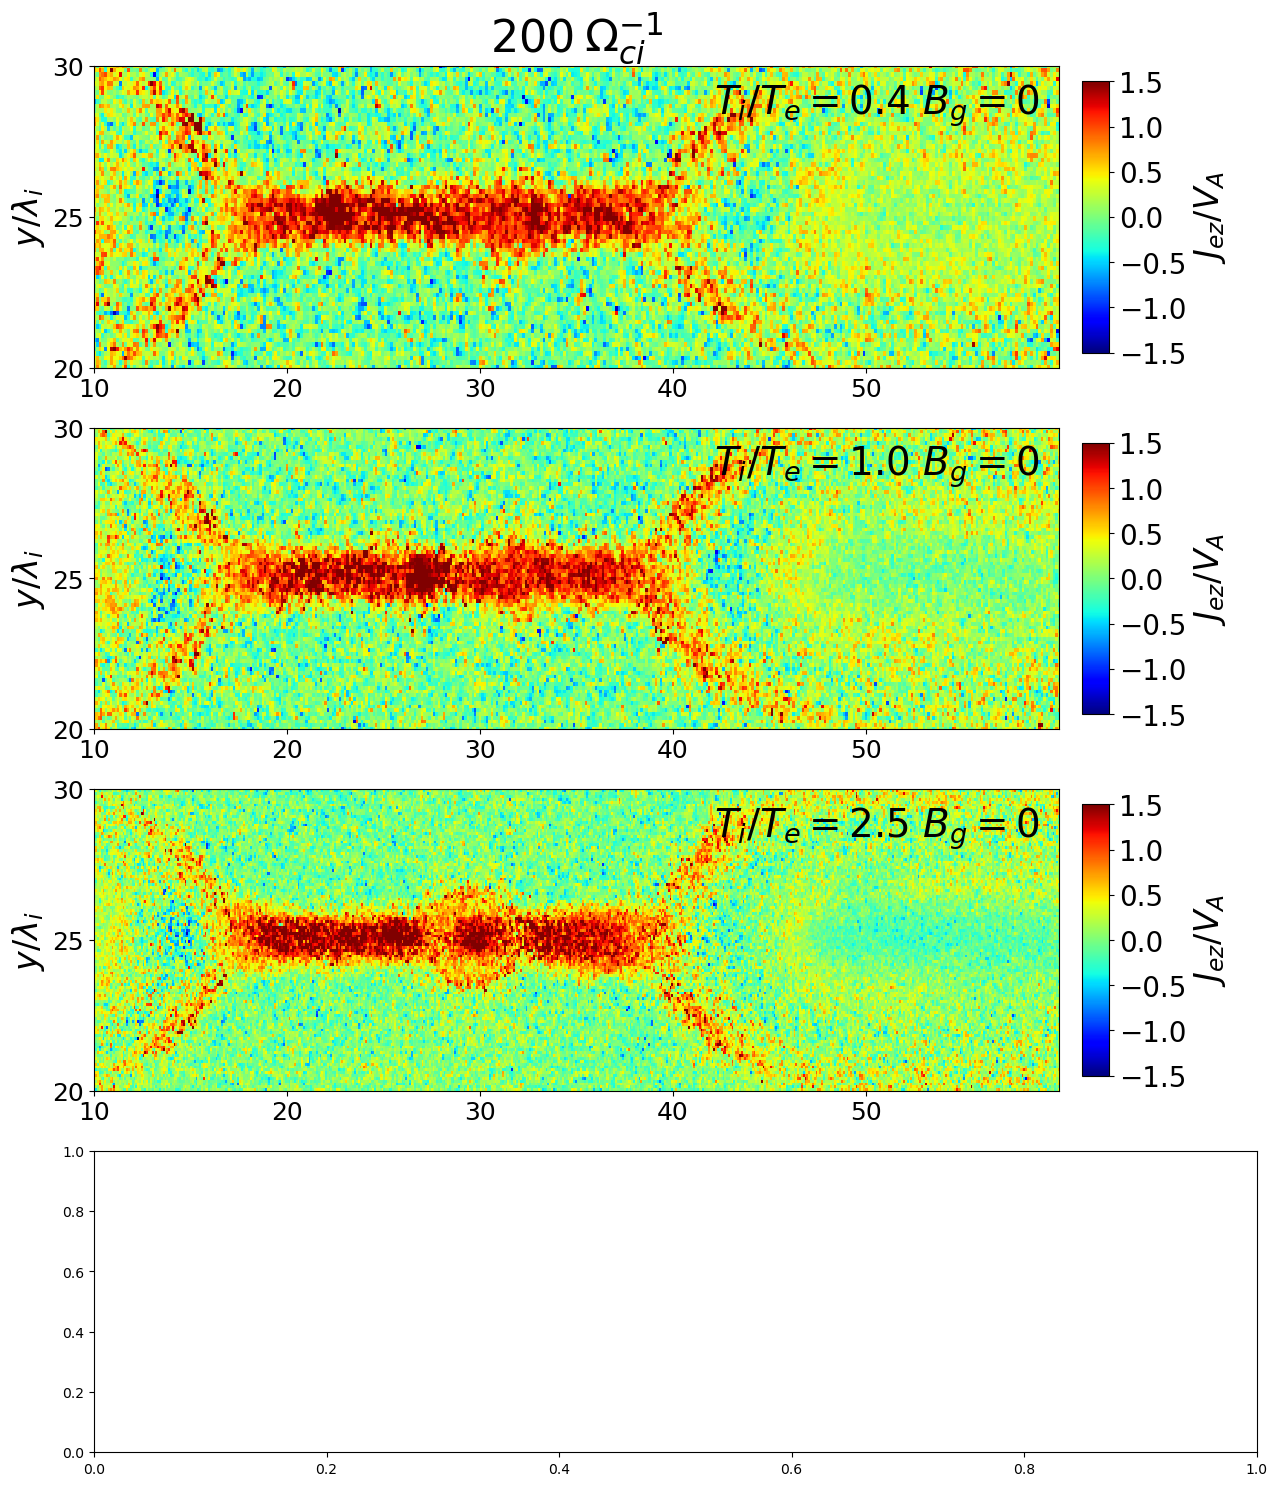

In [5]:
fig = plt.figure(figsize=(15, 18))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

interval = 1
number_of_result = 50
dirname1 = "mr2008_mr=4_a=2_tr=2.5"
dirname2 = "mr2008_mr=4_a=2_tr=1"
dirname3 = "mr2008_mr=4_a=2_tr=0.4"

t_r = 2.5
T_i  = (B0**2 / 2.0 / mu_0) / (n_i + n_e * t_r)
T_e = T_i * t_r
q_unit = np.sqrt(epsilon0 * T_e / n_e)
q_electron = -1 * q_unit
q_ion = r_q * q_unit
omega_pi = np.sqrt(n_i * q_ion**2 / m_ion / epsilon0)
omega_ce = q_electron * B0 / m_electron
omega_ci = q_ion * B0 / m_ion
ion_inertial_length = c / omega_pi
V_A = B0 / np.sqrt(mu_0 * n_i * m_ion)
n_x = int(ion_inertial_length * 100)
n_y = int(ion_inertial_length * 50)
x_min = 0.5 * dx
y_min = 0.5 * dy
x_max = n_x * dx - dx
y_max = n_y * dy - dy
x_coordinate = np.arange(0.0, x_max+dx, dx)
y_coordinate = np.arange(0.0, y_max+dy, dy)
X, Y = np.meshgrid(x_coordinate, y_coordinate) / ion_inertial_length
file_num = int(2/omega_ci) * number_of_result
zeroth_moment = np.loadtxt(f'{dirname1}/mr2008_zeroth_moment_electron_{file_num}.csv', delimiter=',')[:, 0].reshape(n_x, n_y)
first_moment = np.loadtxt(f'{dirname1}/mr2008_first_moment_electron_{file_num}.csv', delimiter=',')[:, 0:3].reshape(n_x, n_y, 3)
current_ez = first_moment[:, :, 2] / (zeroth_moment + 1e-10)
mappable = ax1.pcolormesh(X, Y, current_ez.T / V_A, cmap='jet', vmin=-1.5, vmax=1.5)
cbar = fig.colorbar(mappable, ax=ax1, pad=0.02, shrink=0.9, aspect=10, ticks=np.arange(-1.5, 1.6, 0.5))
cbar.set_label(r'$J_{ez} / V_A$', fontsize=24)
cbar.ax.tick_params(labelsize=20)
ax1.set_ylabel('$y / \lambda_i$', fontsize=24)
ax1.set_xlim(10, 60)
ax1.set_ylim(20, 30)
ax1.set_xticks([10, 20, 30, 40, 50])
ax1.set_yticks([20, 25, 30])
ax1.tick_params(labelsize=18)
ax1.text(0.5, 1.05, str(2 * k) + r"$ \: \Omega_{ci}^{-1}$", ha='center', transform=ax1.transAxes, fontsize=32)
ax1.text(0.98, 0.95, r"$T_i / T_e = $" + str(round(1.0/t_r, 1)) + " " + r"$B_g = 0$", va='top', ha='right', transform=ax1.transAxes, fontsize=28)

t_r = 1.0
T_i  = (B0**2 / 2.0 / mu_0) / (n_i + n_e * t_r)
T_e = T_i * t_r
q_unit = np.sqrt(epsilon0 * T_e / n_e)
q_electron = -1 * q_unit
q_ion = r_q * q_unit
omega_pi = np.sqrt(n_i * q_ion**2 / m_ion / epsilon0)
omega_ce = q_electron * B0 / m_electron
omega_ci = q_ion * B0 / m_ion
ion_inertial_length = c / omega_pi
V_A = B0 / np.sqrt(mu_0 * n_i * m_ion)
n_x = int(ion_inertial_length * 100)
n_y = int(ion_inertial_length * 50)
x_min = 0.5 * dx
y_min = 0.5 * dy
x_max = n_x * dx - dx
y_max = n_y * dy - dy
x_coordinate = np.arange(0.0, x_max+dx, dx)
y_coordinate = np.arange(0.0, y_max+dy, dy)
X, Y = np.meshgrid(x_coordinate, y_coordinate) / ion_inertial_length
file_num = int(2/omega_ci) * number_of_result
zeroth_moment = np.loadtxt(f'{dirname2}/mr2008_zeroth_moment_electron_{file_num}.csv', delimiter=',')[:, 0].reshape(n_x, n_y)
first_moment = np.loadtxt(f'{dirname2}/mr2008_first_moment_electron_{file_num}.csv', delimiter=',')[:, 0:3].reshape(n_x, n_y, 3)
current_ez = first_moment[:, :, 2] / (zeroth_moment + 1e-10)
mappable = ax2.pcolormesh(X, Y, current_ez.T / V_A, cmap='jet', vmin=-1.5, vmax=1.5)
cbar = fig.colorbar(mappable, ax=ax2, pad=0.02, shrink=0.9, aspect=10, ticks=np.arange(-1.5, 1.6, 0.5))
cbar.set_label(r'$J_{ez} / V_A$', fontsize=24)
cbar.ax.tick_params(labelsize=20)
ax2.set_ylabel('$y / \lambda_i$', fontsize=24)
ax2.set_xlim(10, 60)
ax2.set_ylim(20, 30)
ax2.set_xticks([10, 20, 30, 40, 50])
ax2.set_yticks([20, 25, 30])
ax2.tick_params(labelsize=18)
ax2.text(0.98, 0.95, r"$T_i / T_e = $" + str(round(1.0/t_r, 1)) + " " + r"$B_g = 0$", va='top', ha='right', transform=ax2.transAxes, fontsize=28)

t_r = 0.4
T_i  = (B0**2 / 2.0 / mu_0) / (n_i + n_e * t_r)
T_e = T_i * t_r
q_unit = np.sqrt(epsilon0 * T_e / n_e)
q_electron = -1 * q_unit
q_ion = r_q * q_unit
omega_pi = np.sqrt(n_i * q_ion**2 / m_ion / epsilon0)
omega_ce = q_electron * B0 / m_electron
omega_ci = q_ion * B0 / m_ion
ion_inertial_length = c / omega_pi
V_A = B0 / np.sqrt(mu_0 * n_i * m_ion)
n_x = int(ion_inertial_length * 100)
n_y = int(ion_inertial_length * 50)
x_min = 0.5 * dx
y_min = 0.5 * dy
x_max = n_x * dx - dx
y_max = n_y * dy - dy
x_coordinate = np.arange(0.0, x_max+dx, dx)
y_coordinate = np.arange(0.0, y_max+dy, dy)
X, Y = np.meshgrid(x_coordinate, y_coordinate) / ion_inertial_length
file_num = int(2/omega_ci) * number_of_result
zeroth_moment = np.loadtxt(f'{dirname3}/mr2008_zeroth_moment_electron_{file_num}.csv', delimiter=',')[:, 0].reshape(n_x, n_y)
first_moment = np.loadtxt(f'{dirname3}/mr2008_first_moment_electron_{file_num}.csv', delimiter=',')[:, 0:3].reshape(n_x, n_y, 3)
current_ez = first_moment[:, :, 2] / (zeroth_moment + 1e-10)
mappable = ax3.pcolormesh(X, Y, current_ez.T / V_A, cmap='jet', vmin=-1.5, vmax=1.5)
cbar = fig.colorbar(mappable, ax=ax3, pad=0.02, shrink=0.9, aspect=10, ticks=np.arange(-1.5, 1.6, 0.5))
cbar.set_label(r'$J_{ez} / V_A$', fontsize=24)
cbar.ax.tick_params(labelsize=20)
ax3.set_ylabel('$y / \lambda_i$', fontsize=24)
ax3.set_xlim(10, 60)
ax3.set_ylim(20, 30)
ax3.set_xticks([10, 20, 30, 40, 50])
ax3.set_yticks([20, 25, 30])
ax3.tick_params(labelsize=18)
ax3.text(0.98, 0.95, r"$T_i / T_e = $" + str(round(1.0/t_r, 1)) + " " + r"$B_g = 0$", va='top', ha='right', transform=ax3.transAxes, fontsize=28)

---
---
---

In [17]:
dirname = "mr2008"
zeroth_order_ion = np.loadtxt(f'{dirname}/mr2008_zeroth_moment_ion_{0}.csv', delimiter=',')[:, 0].reshape(n_x, n_y)
zeroth_order_electron = np.loadtxt(f'{dirname}/mr2008_zeroth_moment_electron_{0}.csv', delimiter=',')[:, 0].reshape(n_x, n_y)
first_order_ion = np.loadtxt(f'{dirname}/mr2008_first_moment_ion_{0}.csv', delimiter=',')[:, 0:3].reshape(n_x, n_y, 3)
first_order_electron = np.loadtxt(f'{dirname}/mr2008_first_moment_electron_{0}.csv', delimiter=',')[:, 0:3].reshape(n_x, n_y, 3)
second_order_ion = np.loadtxt(f'{dirname}/mr2008_second_moment_ion_{0}.csv', delimiter=',')[:, 0:9].reshape(n_x, n_y, 3, 3)
second_order_electron = np.loadtxt(f'{dirname}/mr2008_second_moment_electron_{0}.csv', delimiter=',')[:, 0:9].reshape(n_x, n_y, 3, 3)

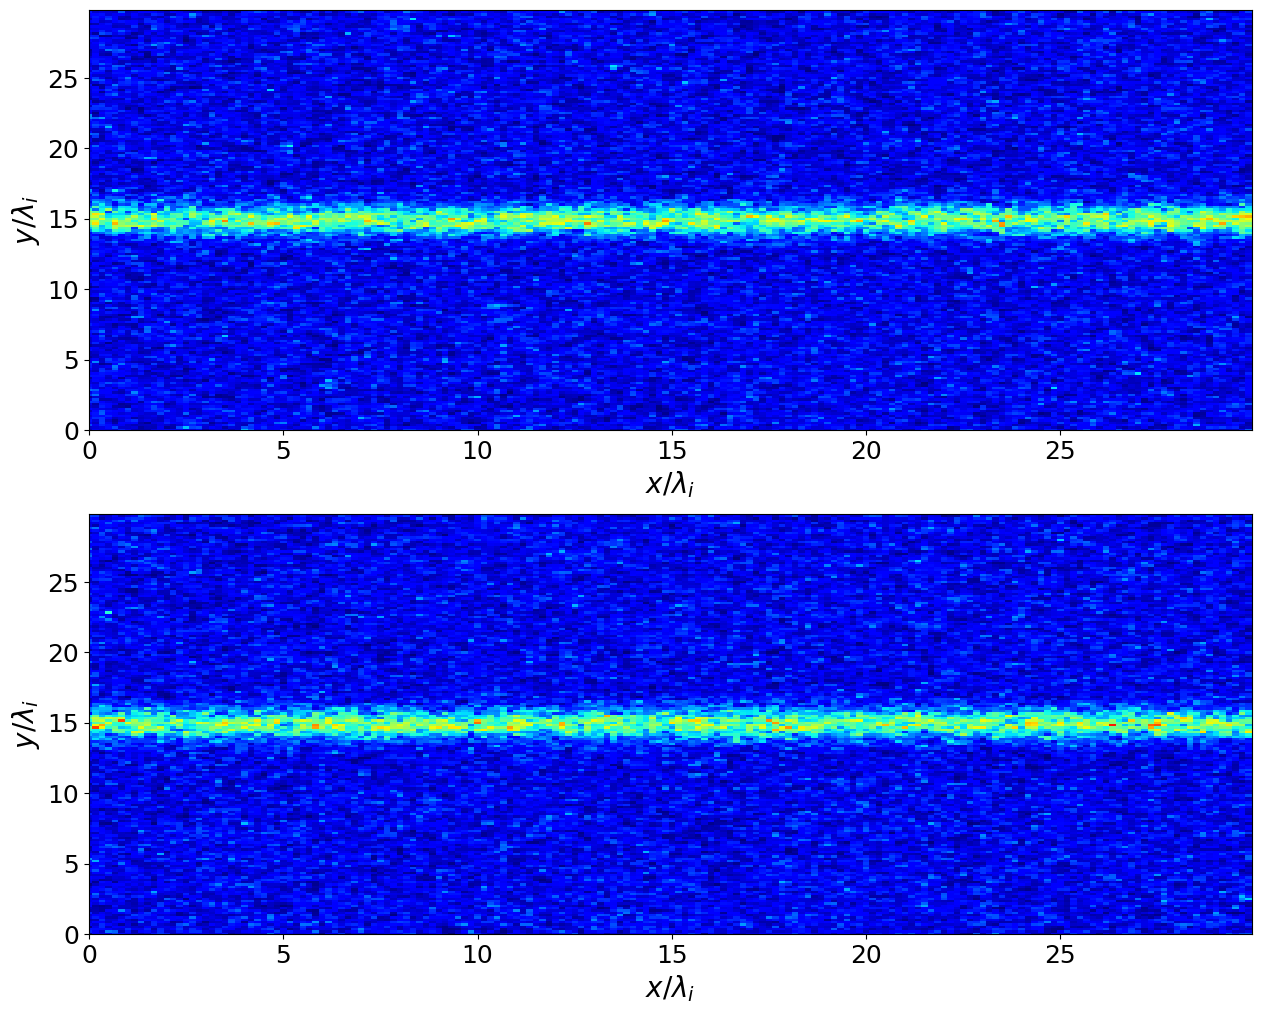

In [18]:
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

X, Y = np.meshgrid(x_coordinate, y_coordinate) / ion_inertial_length

ax1.pcolormesh(X, Y, zeroth_order_ion.T / n_i, cmap='jet', vmin=0.0, vmax=2.0)
ax1.set_xlabel('$x / \lambda_i$', fontsize=20)
ax1.set_ylabel('$y / \lambda_i$', fontsize=20)
ax1.set_xlim(0.0, x_max/2/ion_inertial_length)
ax1.set_ylim(0.0, y_max/ion_inertial_length)
ax1.tick_params(labelsize=18)

ax2.pcolormesh(X, Y, zeroth_order_electron.T / n_e, cmap='jet', vmin=0.0, vmax=2.0)
ax2.set_xlabel('$x / \lambda_i$', fontsize=20)
ax2.set_ylabel('$y / \lambda_i$', fontsize=20)
ax2.set_xlim(0.0, x_max/2/ion_inertial_length)
ax2.set_ylim(0.0, y_max/ion_inertial_length)
ax2.tick_params(labelsize=18)

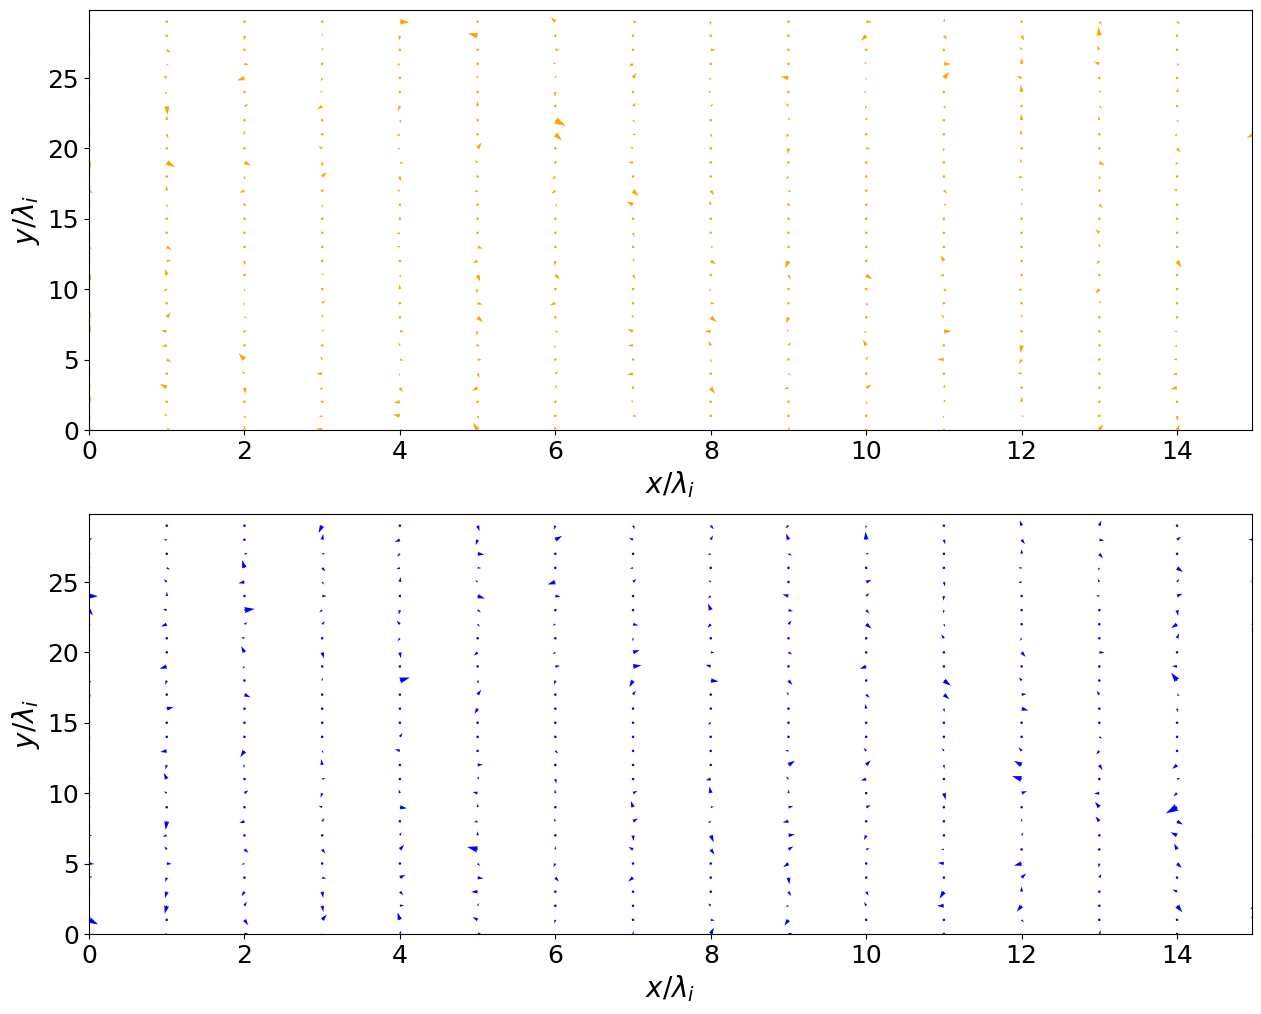

In [19]:
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

X, Y = np.meshgrid(np.arange(200), np.arange(50))
index1 = 1

number_density_ion = np.zeros([200, 50])
number_density_electron = np.zeros([200, 50])
velocity_average_ion = np.zeros([3, 200, 50]) * np.nan
velocity_average_electron = np.zeros([3, 200, 50]) * np.nan
for i in range(0, int(200 / index1)):
    for j in range(50):
        xmin = int(index1*i*ion_inertial_length)
        xmax = int(index1*(i+1)*ion_inertial_length)
        ymin = int(j*ion_inertial_length)
        ymax = int((j+1)*ion_inertial_length)
        number_density_ion[index1*i, j] = np.mean(zeroth_order_ion[xmin:xmax, ymin:ymax]) 
        number_density_electron[index1*i, j] = np.mean(zeroth_order_electron[xmin:xmax, ymin:ymax]) 
        velocity_average_ion[0, index1*i, j] = np.mean(first_order_ion[xmin:xmax, ymin:ymax, 0]) / (number_density_ion[index1*i, j] + 1e-10)
        velocity_average_ion[1, index1*i, j] = np.mean(first_order_ion[xmin:xmax, ymin:ymax, 1]) / (number_density_ion[index1*i, j] + 1e-10)
        velocity_average_ion[2, index1*i, j] = np.mean(first_order_ion[xmin:xmax, ymin:ymax, 2]) / (number_density_ion[index1*i, j] + 1e-10)
        velocity_average_electron[0, index1*i, j] = np.mean(first_order_electron[xmin:xmax, ymin:ymax, 0]) / (number_density_electron[index1*i, j] + 1e-10)
        velocity_average_electron[1, index1*i, j] = np.mean(first_order_electron[xmin:xmax, ymin:ymax, 1]) / (number_density_electron[index1*i, j] + 1e-10)
        velocity_average_electron[2, index1*i, j] = np.mean(first_order_electron[xmin:xmax, ymin:ymax, 2]) / (number_density_electron[index1*i, j] + 1e-10)

ax1.quiver(X, Y, velocity_average_ion[0].T/V_A, velocity_average_ion[1].T/V_A, scale=20, color='orange')
ax1.set_xlabel('$x / \lambda_i$', fontsize=20)
ax1.set_ylabel('$y / \lambda_i$', fontsize=20)
ax1.set_xlim(0.0, x_max/4/ion_inertial_length)
ax1.set_ylim(0.0, y_max/ion_inertial_length)
ax1.tick_params(labelsize=18)

ax2.quiver(X, Y, velocity_average_electron[0].T/V_A, velocity_average_electron[1].T/V_A, scale=30, color='blue')
ax2.set_xlabel('$x / \lambda_i$', fontsize=20)
ax2.set_ylabel('$y / \lambda_i$', fontsize=20)
ax2.set_xlim(0.0, x_max/4/ion_inertial_length)
ax2.set_ylim(0.0, y_max/ion_inertial_length)
ax2.tick_params(labelsize=18)

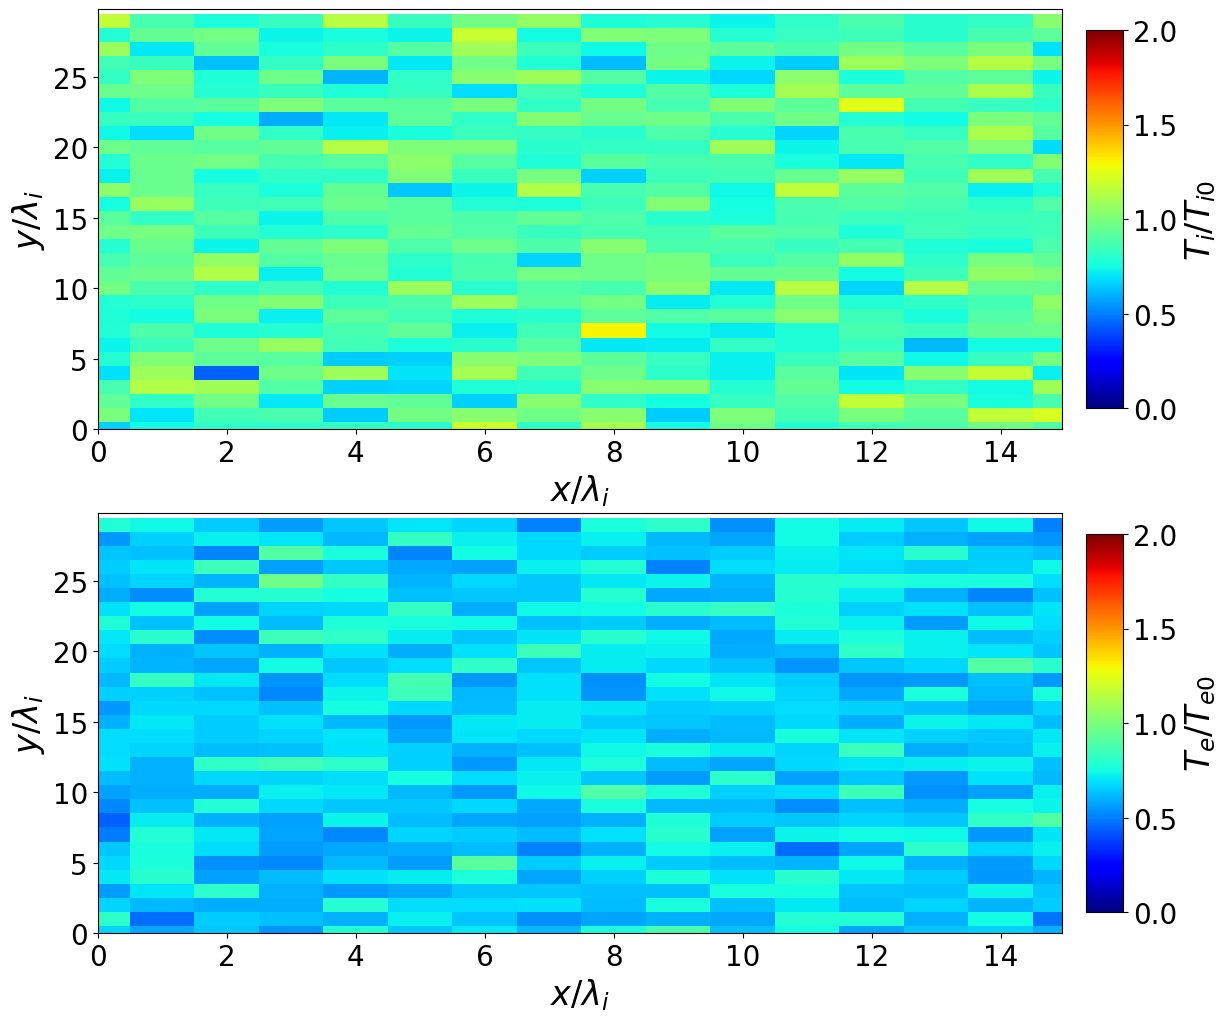

In [20]:
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

number_density_ion = np.zeros([200, 50])
number_density_electron = np.zeros([200, 50])
velocity_average_ion = np.zeros([3, 200, 50])
velocity_average_electron = np.zeros([3, 200, 50])
temperature_average_ion = np.zeros([3, 3, 200, 50])
temperature_average_electron = np.zeros([3, 3, 200, 50])
for i in range(200):
    for j in range(50):
        xmin = int(i*ion_inertial_length)
        xmax = int((i+1)*ion_inertial_length)
        ymin = int(j*ion_inertial_length)
        ymax = int((j+1)*ion_inertial_length)
        number_density_ion[i, j] = np.mean(zeroth_order_ion[xmin:xmax, ymin:ymax]) 
        number_density_electron[i, j] = np.mean(zeroth_order_electron[xmin:xmax, ymin:ymax]) 
        velocity_average_ion[0, i, j] = np.mean(first_order_ion[xmin:xmax, ymin:ymax, 0]) / (number_density_ion[i, j] + 1e-10)
        velocity_average_ion[1, i, j] = np.mean(first_order_ion[xmin:xmax, ymin:ymax, 1]) / (number_density_ion[i, j] + 1e-10)
        velocity_average_ion[2, i, j] = np.mean(first_order_ion[xmin:xmax, ymin:ymax, 2]) / (number_density_ion[i, j] + 1e-10)
        velocity_average_electron[0, i, j] = np.mean(first_order_electron[xmin:xmax, ymin:ymax, 0]) / (number_density_electron[i, j] + 1e-10)
        velocity_average_electron[1, i, j] = np.mean(first_order_electron[xmin:xmax, ymin:ymax, 1]) / (number_density_electron[i, j] + 1e-10)
        velocity_average_electron[2, i, j] = np.mean(first_order_electron[xmin:xmax, ymin:ymax, 2]) / (number_density_electron[i, j] + 1e-10)

        temperature_average_ion[0, 0, i, j] = np.mean(second_order_ion[xmin:xmax, ymin:ymax, 0, 0]) / (number_density_ion[i, j] + 1e-10) - velocity_average_ion[0, i, j]**2
        temperature_average_ion[1, 1, i, j] = np.mean(second_order_ion[xmin:xmax, ymin:ymax, 1, 1]) / (number_density_ion[i, j] + 1e-10) - velocity_average_ion[1, i, j]**2
        temperature_average_ion[2, 2, i, j] = np.mean(second_order_ion[xmin:xmax, ymin:ymax, 2, 2]) / (number_density_ion[i, j] + 1e-10) - velocity_average_ion[2, i, j]**2
        temperature_average_electron[0, 0, i, j] = np.mean(second_order_electron[xmin:xmax, ymin:ymax, 0, 0]) / (number_density_electron[i, j] + 1e-10) - velocity_average_electron[0, i, j]**2
        temperature_average_electron[1, 1, i, j] = np.mean(second_order_electron[xmin:xmax, ymin:ymax, 1, 1]) / (number_density_electron[i, j] + 1e-10) - velocity_average_electron[1, i, j]**2
        temperature_average_electron[2, 2, i, j] = np.mean(second_order_electron[xmin:xmax, ymin:ymax, 2, 2]) / (number_density_electron[i, j] + 1e-10) - velocity_average_electron[2, i, j]**2


mappable1 = ax1.pcolormesh(X, Y, m_ion * temperature_average_ion[0, 0, :, :].T / T_i, cmap='jet', vmin=0.0, vmax=2.0)
cbar = fig.colorbar(mappable1, ax=ax1, pad=0.02, shrink=0.9, aspect=10, ticks=np.arange(0.0, 2.1, 0.5))
cbar.set_label(r'$T_i / T_{i0}$', fontsize=24)
cbar.ax.tick_params(labelsize=20)
ax1.set_xlabel('$x / \lambda_i$', fontsize=24)
ax1.set_ylabel('$y / \lambda_i$', fontsize=24)
ax1.set_xlim(0.0, x_max/4/ion_inertial_length)
ax1.set_ylim(0.0, y_max/ion_inertial_length)
ax1.tick_params(labelsize=20)

mappable2 = ax2.pcolormesh(X, Y, m_electron * temperature_average_electron[0, 0, :, :].T / T_e, cmap='jet', vmin=0.0, vmax=2.0)
cbar = fig.colorbar(mappable2, ax=ax2, pad=0.02, shrink=0.9, aspect=10, ticks=np.arange(0.0, 2.1, 0.5))
cbar.set_label(r'$T_e / T_{e0}$', fontsize=24)
cbar.ax.tick_params(labelsize=20)
ax2.set_xlabel('$x / \lambda_i$', fontsize=24)
ax2.set_ylabel('$y / \lambda_i$', fontsize=24)
ax2.set_xlim(0.0, x_max/4/ion_inertial_length)
ax2.set_ylim(0.0, y_max/ion_inertial_length)
ax2.tick_params(labelsize=20)